In [1]:
#import sys
#formerPath = sys.path
#sys.path.append('./code/')
#sys.path.append('./BS/')

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import sklearn as skl


import bootstrapping
import dataSetConstruction
import backtest
import BS
import loadData
import plotTools
import SSVI
import neuralNetwork


import importlib

Instructions for updating:
non-resource variables are not supported in the long term


# Load data with google colab 

#### From excel file :

You will find in github repository six days of data.
For each day you need to load six csv files :
- *underlying.csv* for the stock value.
- *locvol.csv* for the local volatility calibrated with tree pricing and tikhonov volatility (see Crépey (2002)).
- *dividend.csv* for dividend extracted from put-call parity.
- *discount.csv* for zero-coupon curve. 
- *dataTrain.csv* for prices and/or implied volatility used in training set.
- *dataTest.csv* for prices and/or implied volatility used in testing set.

In [ ]:
#Load csv files to get data
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
workingFolder = "./data/09082001/"

Bootstrap discounting


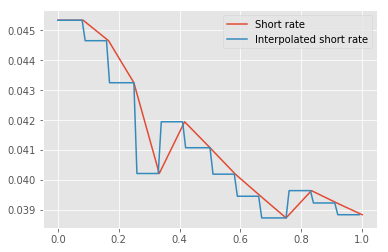

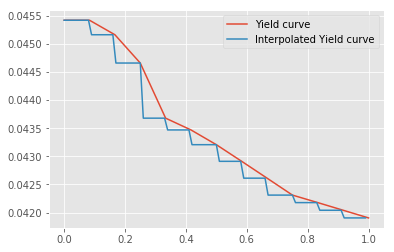

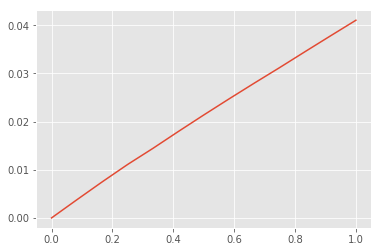

Bootstrap dividend


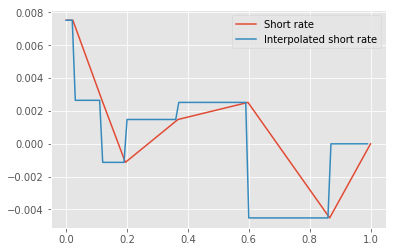

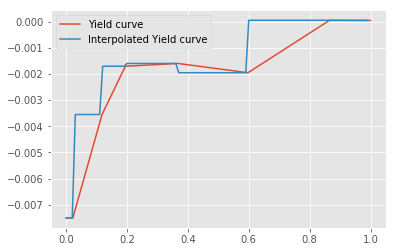

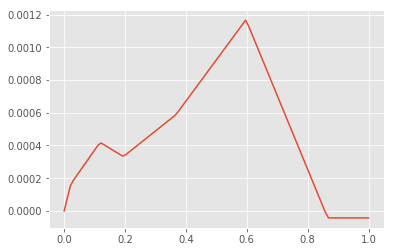

In [ ]:
#Read csv files as dataFrames
trainingSet, testingSet, bootstrap, S0 = loadData.loadDataFromCSV(workingFolder,
                                                                  "9_8_2001__filterdax")

#### From Dat files

Tikhonov PDE repricing error on training set :  2.4207935408017573
Bootstrap discounting


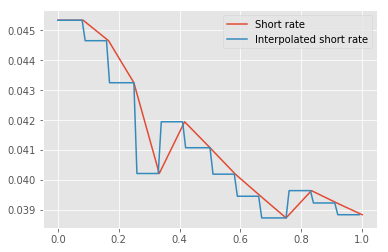

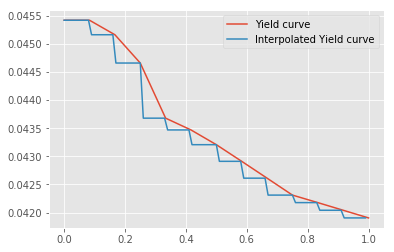

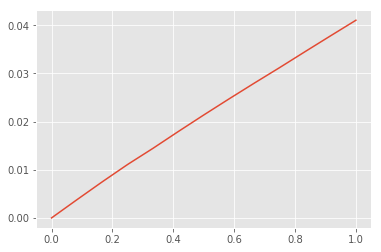

Bootstrap dividend


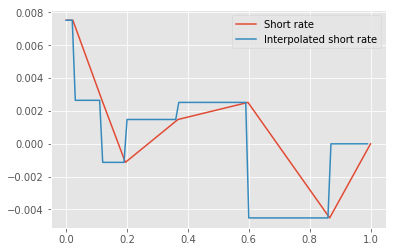

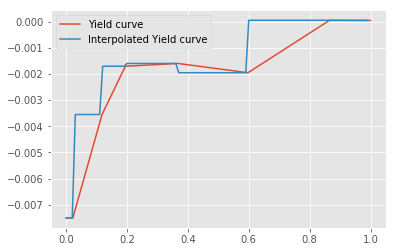

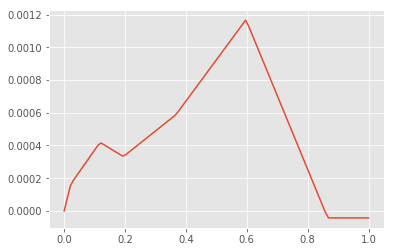

In [ ]:
trainingSet, testingSet, bootstrap, S0 = loadData.loadDataFromDat(workingFolder,
                                                                  "9_8_2001__filterdax")

In [ ]:
importlib.reload(loadData)

<module 'loadData' from './code/loadData.py'>

In [ ]:
pd.options.mode.chained_assignment = 'raise'

#### SPX Data

We assume a piecewise constant discount short rate $r$ and a piecewise constant dividend short rate $q$.

We estimate the "zero coupon dividend" $D(T) = e^{-\int_{0}^{T} q_s ds}$ by regressing it against maturity :
$$e^{-\int_{0}^{T} q_s ds} = \frac{C(T,K) - P(T,K) + K e^{-\int_{0}^{T} r_s ds}}{S_0}$$


Then we have $\hat{q}_t = - \frac{ \log{D(\overline{T})} - \log{D(\underline{T})} }{ \overline{T} - \underline{T} }$ with $\overline{T}$ the smallest discretized maturity greater than $T$ and $\underline{T}$ the grestest discretized maturity inferior than $T$.

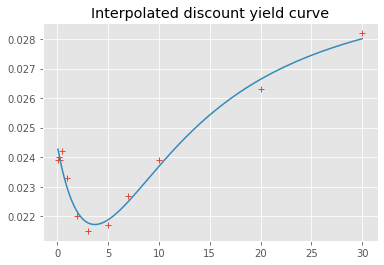

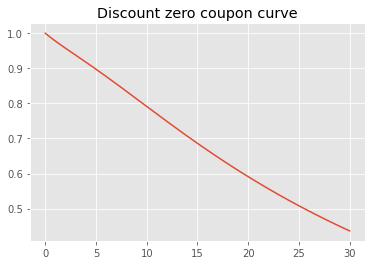

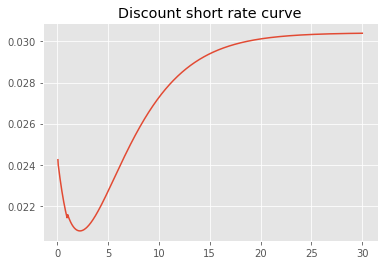

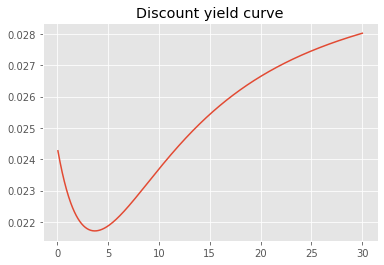

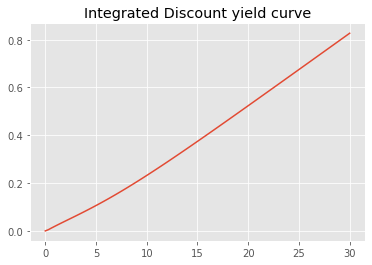

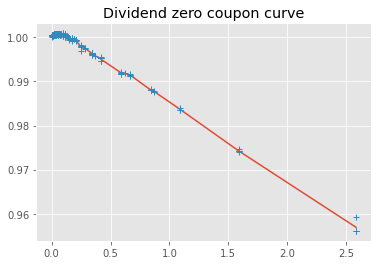

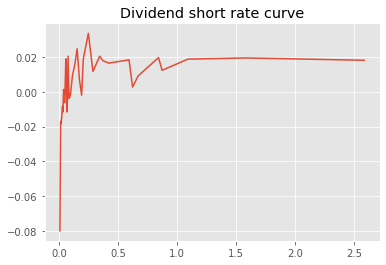

/content/bootstrapping.py:271: RuntimeWarning: invalid value encountered in double_scalars
  return (1 / x - 1) / float(t)


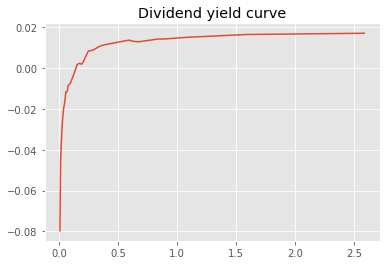

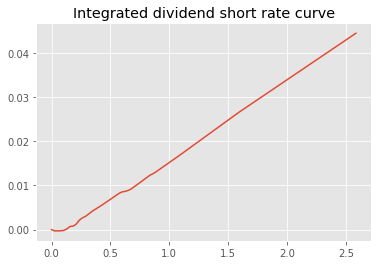

In [3]:
workingFolder = "./"#"./data/"
fileName = "Option_SPX_18_Mai_2019Feuille2.xlsm"
asOfDate = "2019-05-18"
trainingSet, testingSet, bootstrap, S0 = loadData.loadCBOTData(workingFolder, fileName, asOfDate)

In [ ]:
importlib.reload(bootstrapping)

<module 'dataSetConstruction' from './code/dataSetConstruction.py'>

####  Eurostoxx data

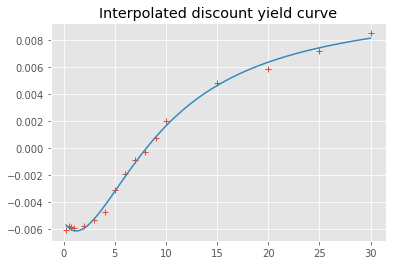

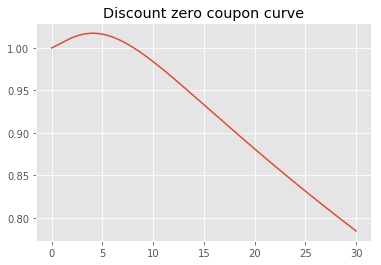

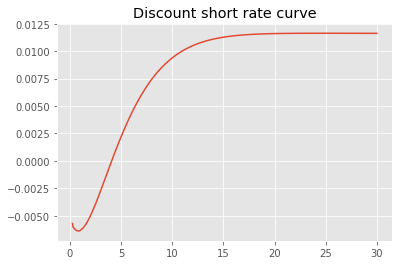

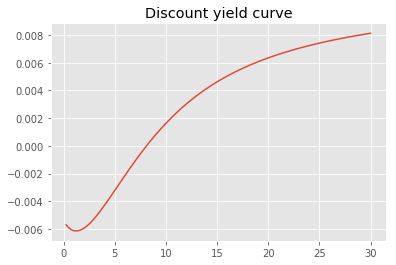

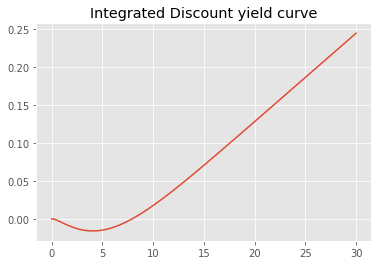

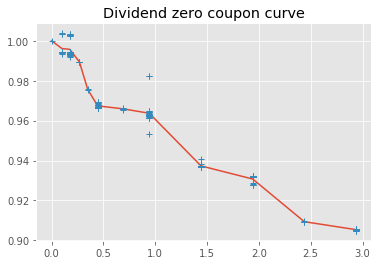

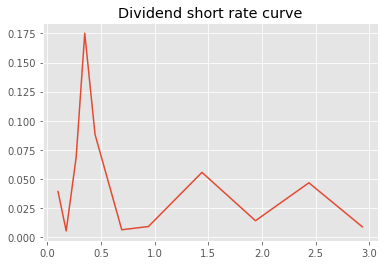

./code/bootstrapping.py:271: RuntimeWarning: invalid value encountered in double_scalars
  return (1 / x - 1) / float(t)


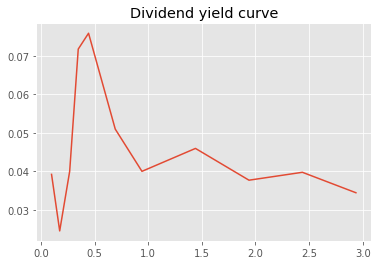

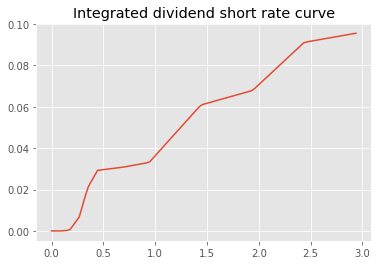

In [ ]:
workingFolder = "./data/"
asOfDate = "2019-01-10"
filename = "Data_EuroStoxx50_20190110_all_for_Marc.xlsx"
trainingSet, testingSet, bootstrap, S0 = loadData.loadESXData(workingFolder, filename, asOfDate)

In [ ]:
bootstrap.discountShortRate(10)

array(0.009402)

# Formatting data

### Boostsrapping Rate Curve


- For bootstrapping short rate $r$ and dividend rate $q$, we assume piecewise constant short rate for risk free rate and dividend i.e. 
$\exp{(-\int_{0}^{T} r_t d_t)} = \exp{(-\sum_{i} r_i h)}$ and $\exp{(\int_{0}^{T} q_t d_t)} = \exp{(\sum_{i} q_i h)}$.
- $\forall i \in \{0,..,N\}$ with $ t_0 = 0$ and $t_N = T$, we have that $\frac{\log{B(0,t_{i+1})} - \log{B(0,t_i)}}{h} = r_i$ with $B(0,T_i)$ the price of a bond expiring at time $t_i$. 
- For dividend, we just to substitute $B(0,T_i)$ with with spot action price plus dividend cash flow received until time $T_i$ i.e. $S_{t_0} + \sum\limits_i Div_{t_i}$.
- Then we linearly interpolate $r$ and $q$.
-  Linear interpolation is also used for integrals $\int_{0}^{T} q_t d_t$ and $\int_{0}^{T} r_t d_t$ in order to obtain discount factor or dividend factor. 

**riskFreeIntegral** corresponds to $I_T = \int_{0}^{T} r_u du$.
**riskFreeSpline**  corresponds to $r_u$ evaluated on a subgrid. Interpolated as step function from zero coupons

**divSpreadIntegral** corresponds to $I_T = \int_{0}^{T} q_u du$, can be negative.
**divSpline**  corresponds to $q_u$ evaluated on a subgrid, can be negative.

Training dataset is built on market prices observed on the dax.
Testing dataset is list of prices drawn from an excel provided by Stephane Crépey.
Prices come from the calibrated local volatility with tikhonov regularisation (see Crépey 2002 paper).
Implied volatitilities in both dataset are obtained from local volatility.

These curve satisfy together the call put parity.

Spot level is contained in underlying.csv

### Pricing black-scholes price

#### Change of variable

- In presence of dividend rate $d$ and risk free rate $r$ Dupire formula is :   $$\sigma^2(T,K) = 2 \frac{ \partial_T P(T,K) + (r-q) K \partial_K P(T,K) + qP(T,K)}{K² \partial_{K}^2 P(T,K)}$$ 
with Strike $K$, Maturity $T$, dividend rate $q$ and risk-free rate $r$, $P$ our pricing function. 
- We apply the following change of variable : $$ w(T,k) = \exp{(\int_{0}^{T} q_t dt)} P(T,K)$$ with $K = k \exp{(\int_{0}^{T} (r_t - q_t) dt)} $.

- Then Dupire equation becomes :  $\sigma^2(T,K) = 2 \frac{ \partial_T w(T,k)}{k² \partial_{k}^2 w(T,k)}$. 
- If we learn the mapping $v$ with a neural network then we should obtain quickly by adjoint differentiation $\partial_T w$ and $\partial_{k²}^2 w$ and therefore $\sigma$.


In [ ]:
dataSetConstruction.checkCallPutParity(pd.concat([trainingSet, testingSet]), 
                                       S0, 
                                       bootstrap)

In [4]:
dataSet = trainingSet #Training set
dataSetTest = testingSet #Testing set
dataSet.head()

Price     Delta  ...  logMoneyness  impliedTotalVariance
Strike Maturity                   ...                                    
2600.0 0.093      6.20 -0.072646  ...     -0.095670              0.004522
2625.0 0.112     10.40 -0.105018  ...     -0.086375              0.005029
2650.0 0.342     41.20 -0.220872  ...     -0.078106              0.011947
2700.0 0.342     49.95 -0.266127  ...     -0.059414              0.010763
       0.668     84.90 -0.306604  ...     -0.061836              0.020271

[5 rows x 15 columns]

In [5]:
dataSetTest.head()

Price     Delta  ...  logMoneyness  impliedTotalVariance
Strike Maturity                   ...                                    
1700.0 0.246      0.80 -0.004171  ...     -0.521416              0.042306
2200.0 0.419      9.95 -0.047968  ...     -0.264678              0.028020
2300.0 0.419     14.30 -0.069169  ...     -0.220227              0.024620
2325.0 0.112      1.65 -0.015858  ...     -0.207736              0.009800
2350.0 0.093      1.20 -0.013019  ...     -0.196766              0.008143

[5 rows x 15 columns]

In [6]:
dfCurve = dataSetConstruction.savingData(bootstrap, 
                                         dataSet, 
                                         dataSetTest, 
                                         workingFolder)

Saving bootstrapping under dfCurve.csv
Saving training set under trainingDataSet.csv
Saving bootstrapping under testingDataSet.csv


In [7]:
dataSet.shape

(111, 15)

In [8]:
dataSetTest.shape

(436, 15)

In [9]:
S0

2859.53

In [10]:
def getCall(df):
    return df[df["OptionType"]==1]
def getPut(df):
    return df[df["OptionType"]==-1]

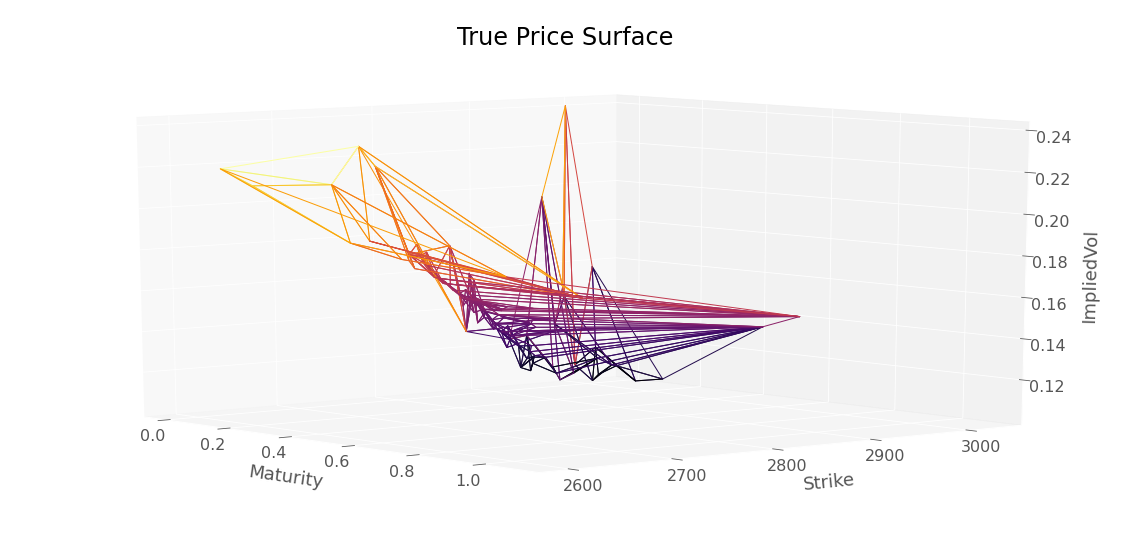

In [11]:
plotTools.plotSerie(getPut(trainingSet)["ImpliedVol"], 
                    yMin=0,
                    yMax=3*S0, 
                    Title = 'True Price Surface')

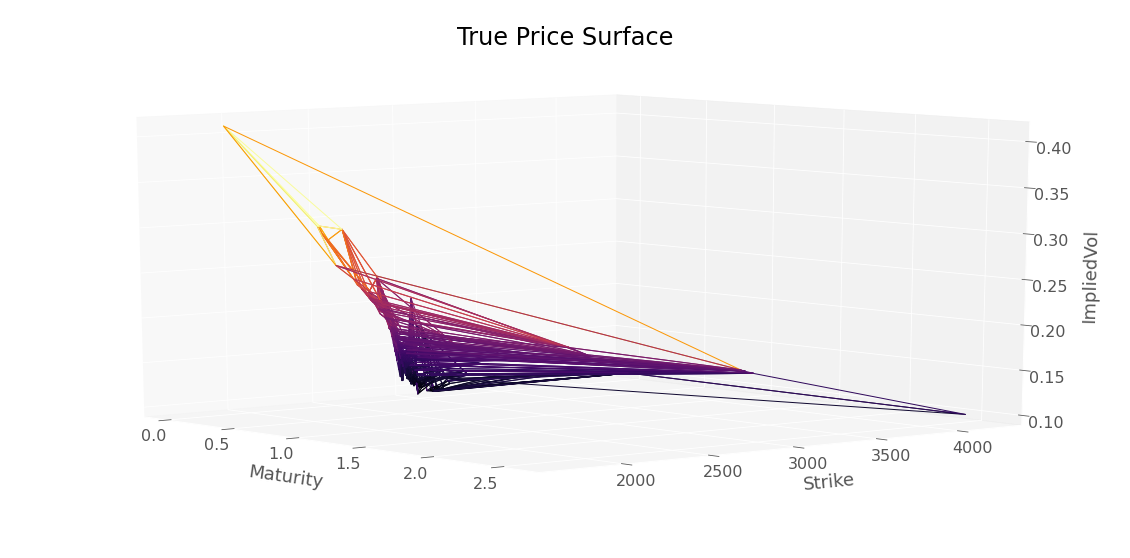

In [12]:
plotTools.plotSerie(getPut(testingSet)["ImpliedVol"], 
                    yMin=0,
                    yMax=3*S0, 
                    Title = 'True Price Surface')

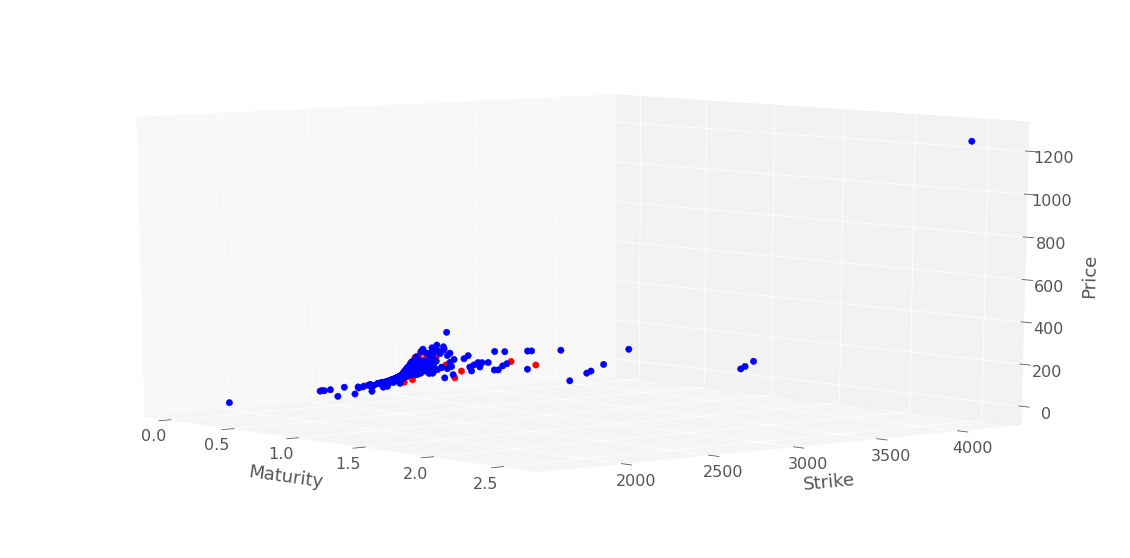

In [13]:
plotTools.plot2Series(getPut(testingSet)["Price"], 
                      getPut(trainingSet)["Price"], 
                      yMin=0,
                      yMax=3*S0, 
                      Title = 'True Price Surface')

In [14]:
testingSet.shape

(436, 15)

In [15]:
trainingSet.shape

(111, 15)

In [16]:
dataSet.head()

Price     Delta  ...  logMoneyness  impliedTotalVariance
Strike Maturity                   ...                                    
2600.0 0.093      6.20 -0.072646  ...     -0.095670              0.004522
2625.0 0.112     10.40 -0.105018  ...     -0.086375              0.005029
2650.0 0.342     41.20 -0.220872  ...     -0.078106              0.011947
2700.0 0.342     49.95 -0.266127  ...     -0.059414              0.010763
       0.668     84.90 -0.306604  ...     -0.061836              0.020271

[5 rows x 15 columns]

## Scaling methods

Use min-max of scaling strike between 0 et 1 for improving stability of neural network training. 

In [44]:
dataSet["locvol"] = np.ones_like(dataSet["ImpliedVol"]) 
dataSetTest["locvol"] = np.ones_like(dataSetTest["ImpliedVol"]) 

In [45]:
scaler = skl.preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler.fit(dataSet)
scaledDataSet = neuralNetwork.transformCustom(dataSet, scaler)
scaledDataSetTest = neuralNetwork.transformCustom(dataSetTest, scaler)

In [46]:
scaledDataSet.head()

Price     Delta  ...  impliedTotalVariance  locvol
Strike Maturity                   ...                              
2600.0 0.093      6.20 -0.072646  ...              0.004522     1.0
2625.0 0.112     10.40 -0.105018  ...              0.005029     1.0
2650.0 0.342     41.20 -0.220872  ...              0.011947     1.0
2700.0 0.342     49.95 -0.266127  ...              0.010763     1.0
       0.668     84.90 -0.306604  ...              0.020271     1.0

[5 rows x 16 columns]

In [47]:
#Search strike for ATM option
midS0 = dataSet[dataSet.index.get_level_values("Strike") >= S0].index.get_level_values("Strike").min()

## Plot functions

In [22]:
KMin = 0#0.7 * S0[0]
KMax = 2.0 * S0#1.3 * S0[0]


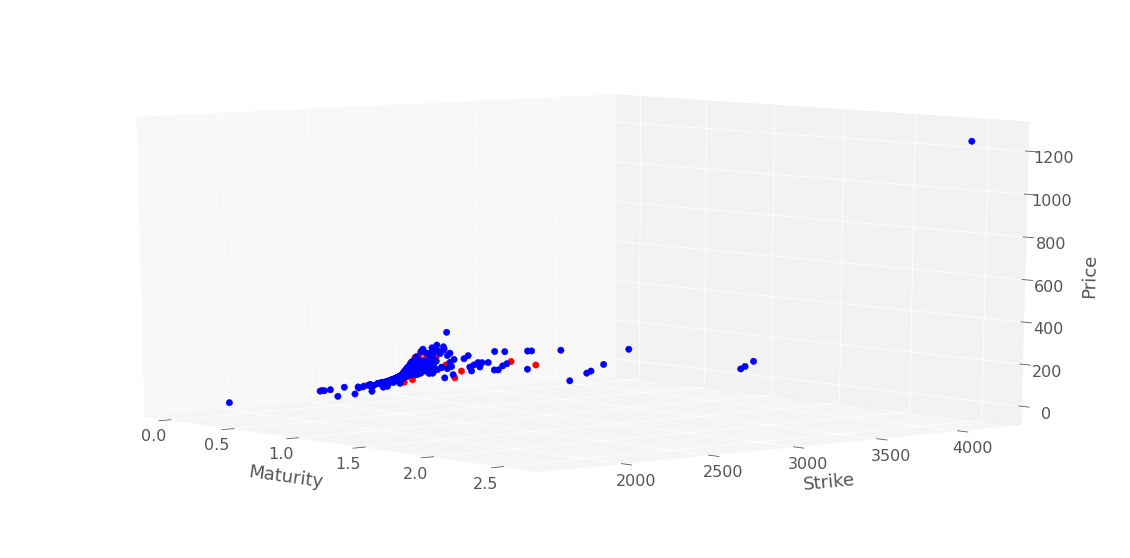

In [23]:
plotTools.plot2Series(dataSetTest[dataSetTest.Maturity > 0]["Price"], 
                      dataSet[dataSet.Maturity > 0]["Price"], 
                      yMin=KMin,
                      yMax=KMax, 
                      Title = 'True Price Surface')

In [24]:
importlib.reload(plotTools)

<module 'plotTools' from '/content/plotTools.py'>

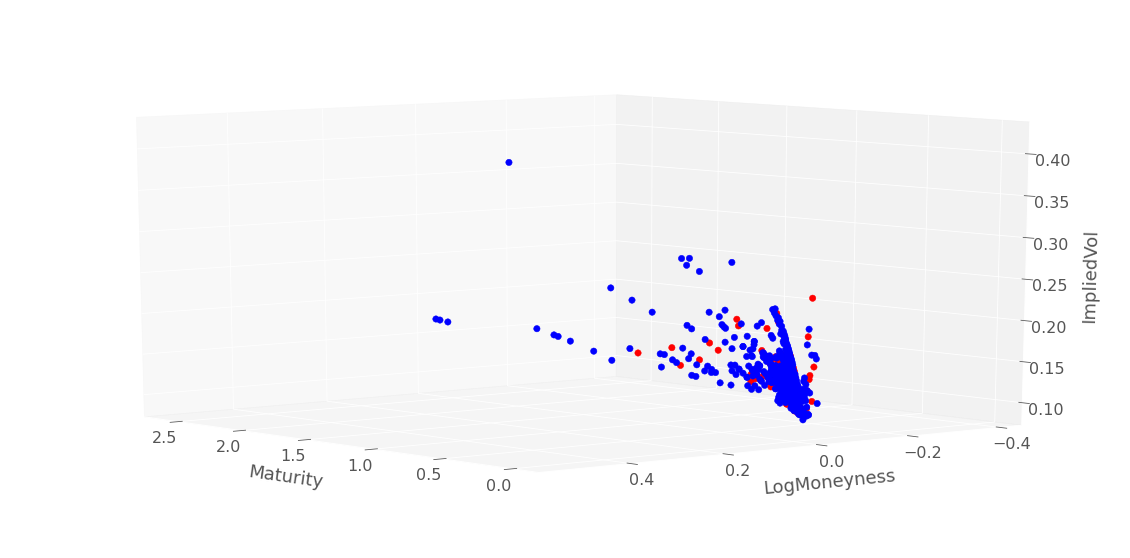

In [25]:
plotTools.plot2Series(plotTools.convertToLogMoneyness(dataSetTest[dataSetTest.Maturity > 0], S0)["ImpliedVol"], 
                      plotTools.convertToLogMoneyness(dataSet[dataSet.Maturity > 0], S0)["ImpliedVol"], 
                      yMin=-1000,
                      yMax=1000, 
                      Title = 'True Implied vol Surfaces', 
                      az=140)

In [26]:
plt.get_cmap("plasma")(0)

(0.050383, 0.029803, 0.527975, 1.0)

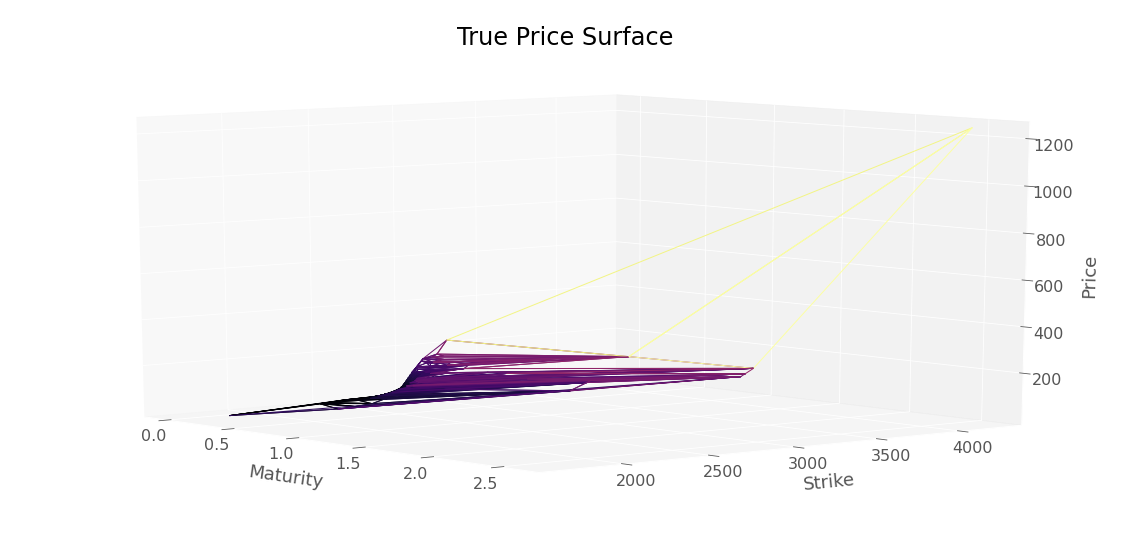

In [27]:
plotTools.plotSerie(dataSetTest[dataSetTest.Maturity > 0]["Price"], 
                    yMin=KMin,
                    yMax=KMax, 
                    Title = 'True Price Surface')

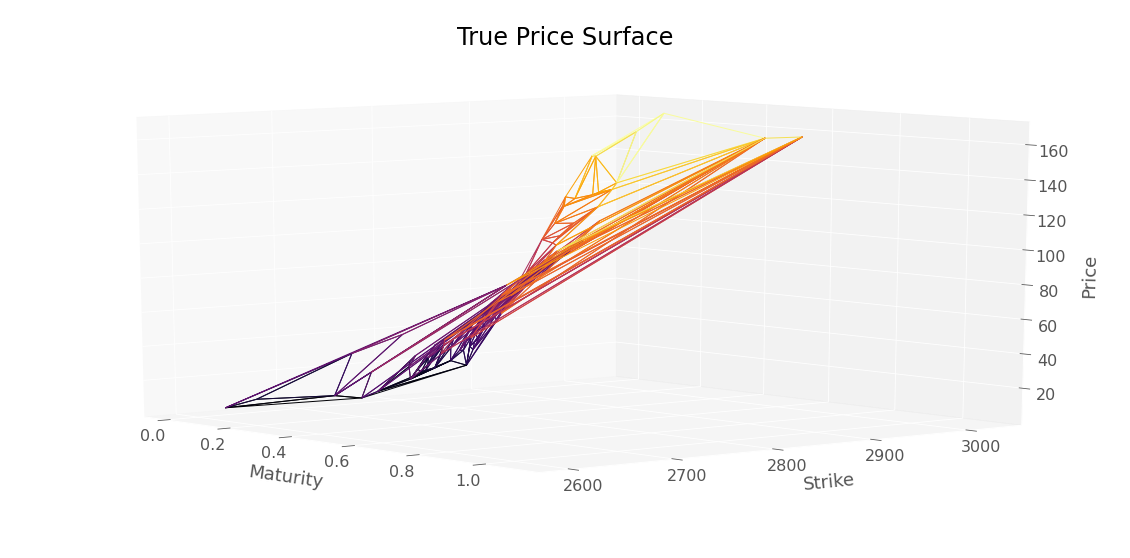

In [28]:
plotTools.plotSerie(dataSet["Price"],
                    yMin=KMin,
                    yMax=KMax, 
                    Title = 'True Price Surface')

In [30]:
neuralNetwork.inverseTransform(scaledDataSet, scaler).head()

Price     Delta  ...  logMoneyness  impliedTotalVariance
Strike Maturity                   ...                                    
2600.0 0.093      6.20 -0.072646  ...     -0.095670              0.004522
2625.0 0.112     10.40 -0.105018  ...     -0.086375              0.005029
2650.0 0.342     41.20 -0.220872  ...     -0.078106              0.011947
2700.0 0.342     49.95 -0.266127  ...     -0.059414              0.010763
       0.668     84.90 -0.306604  ...     -0.061836              0.020271

[5 rows x 15 columns]

### Implied volatility function calibration by bissection

In [31]:
%matplotlib inline

## Learning Implied volatility

In [48]:
hyperparameters = {}
#penalization coefficient
hyperparameters["lambdaLocVol"] = 0.01 #100
hyperparameters["lambdaSoft"] = 10#10 #100 
hyperparameters["lambdaGamma"] = 10#10 #10000

#Derivative soft constraints parameters
hyperparameters["lowerBoundTheta"] = 0.01
hyperparameters["lowerBoundGamma"] = 0.00001

#Local variance parameters
hyperparameters["DupireVarCap"] = 10
hyperparameters["DupireVolLowerBound"] = 0.05
hyperparameters["DupireVolUpperBound"] = 0.40

#Learning scheduler coefficient
hyperparameters["LearningRateStart"] = 0.1
hyperparameters["Patience"] = 100
hyperparameters["batchSize"] = 50
hyperparameters["FinalLearningRate"] = 1e-6
hyperparameters["FixedLearningRate"] = False

#Training parameters
hyperparameters["nbUnits"] = 200 #number of units for hidden layers
hyperparameters["maxEpoch"] = 10000 #maximum number of epochs

In [49]:
importlib.reload(neuralNetwork)

<module 'neuralNetwork' from '/content/neuralNetwork.py'>

In [50]:
res = neuralNetwork.create_train_model_gatheral(neuralNetwork.NNArchitectureVanillaSoftGatheral,
                                                scaledDataSet,
                                                True,
                                                hyperparameters,
                                                scaler,
                                                modelName = "convexSoftGatheralVolModel")
y_pred4G, volLocale4G, dNN_T4G, gNN_K4G, lossSerie4G = res

Iteration :  363 new learning rate :  0.010000000000000002
Best loss (hidden nodes: 200, iterations: 364): -3.99
Best Penalization :  [0.018477045, [0.0, 0.0, 0.0]]
Iteration :  556 new learning rate :  0.0010000000000000002
Best loss (hidden nodes: 200, iterations: 557): -4.75
Best Penalization :  [0.008653979, [0.0, 0.0, 0.0]]
Iteration :  730 new learning rate :  0.00010000000000000003
Best loss (hidden nodes: 200, iterations: 731): -4.77
Best Penalization :  [0.008466008, [3.8029004e-05, 0.0, 0.0]]
Iteration :  6377 new learning rate :  1.0000000000000004e-05
Best loss (hidden nodes: 200, iterations: 6378): -4.78
Best Penalization :  [0.008389404, [7.105572e-06, 0.0, 0.0]]
Best loss (hidden nodes: 200, iterations: 10000): -4.78
Best Penalization :  [0.008383193, [6.0496536e-06, 0.0, 0.0]]
Training Time :  400.17337584495544


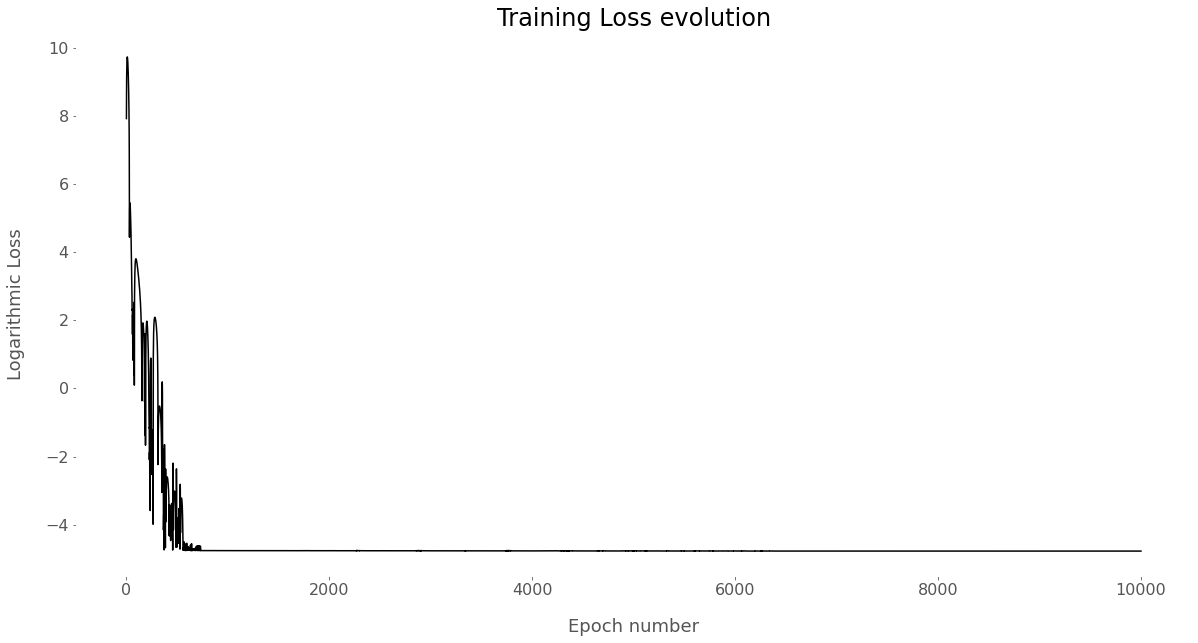

-4.780790328979492

In [51]:
plotTools.plotEpochLoss(lossSerie4G)
lossSerie4G.iloc[-1]

In [52]:
dataSet["impliedTotalVariance"]

Strike  Maturity
2600.0  0.093       0.004522
2625.0  0.112       0.005029
2650.0  0.342       0.011947
2700.0  0.342       0.010763
        0.668       0.020271
                      ...   
2975.0  0.170       0.002110
3000.0  0.016       0.000403
        0.027       0.000372
3015.0  0.112       0.001138
3025.0  0.170       0.001786
Name: impliedTotalVariance, Length: 111, dtype: float64

In [55]:
scaledDataSet

Price     Delta  ...  impliedTotalVariance  locvol
Strike Maturity                    ...                              
2600.0 0.093       6.20 -0.072646  ...              0.004522     1.0
2625.0 0.112      10.40 -0.105018  ...              0.005029     1.0
2650.0 0.342      41.20 -0.220872  ...              0.011947     1.0
2700.0 0.342      49.95 -0.266127  ...              0.010763     1.0
       0.668      84.90 -0.306604  ...              0.020271     1.0
...                 ...       ...  ...                   ...     ...
2975.0 0.170     125.50 -0.791458  ...              0.002110     1.0
3000.0 0.016     138.80 -0.991050  ...              0.000403     1.0
       0.027     138.55 -0.993082  ...              0.000372     1.0
3015.0 0.112     154.15 -0.936849  ...              0.001138     1.0
3025.0 0.170     165.70 -0.899755  ...              0.001786     1.0

[111 rows x 16 columns]

Best loss (hidden nodes: 200, iterations: 0): -4.78
Best Penalization :  [0.008383193, [6.0496536e-06, 0.0, 0.0]]
Number of static arbitrage violations :  0


/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


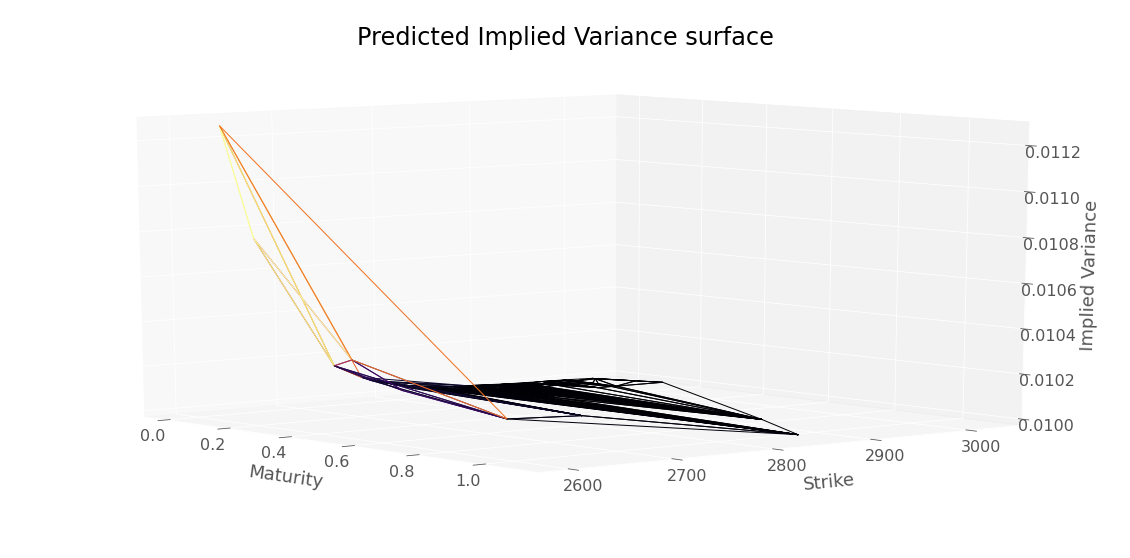

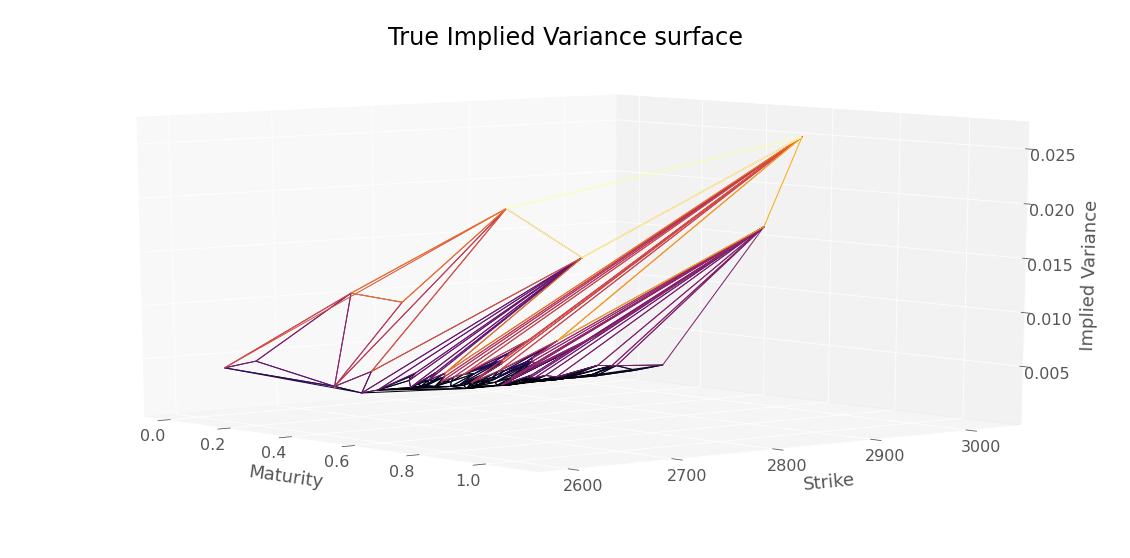

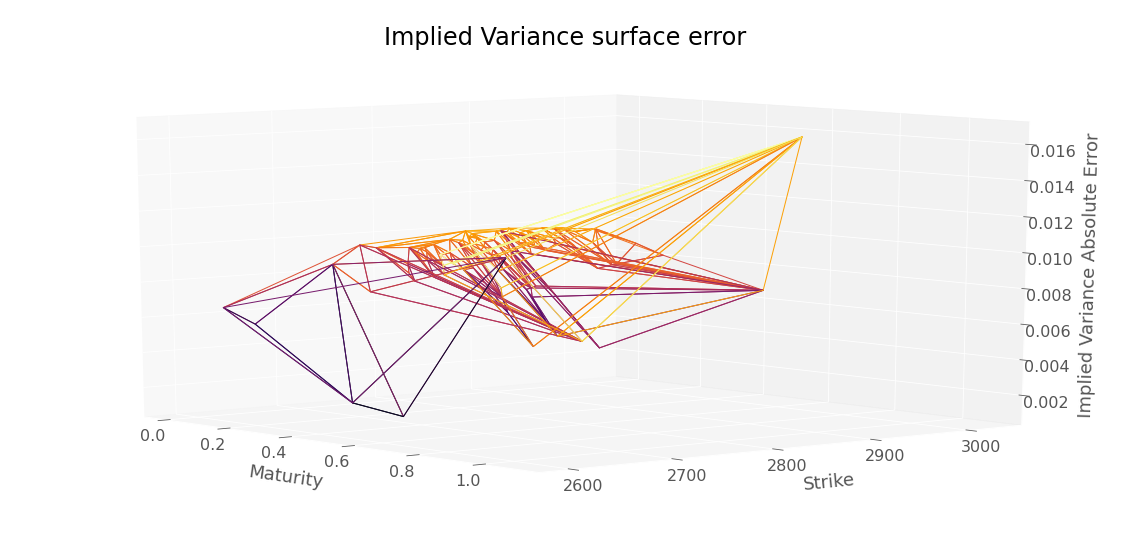

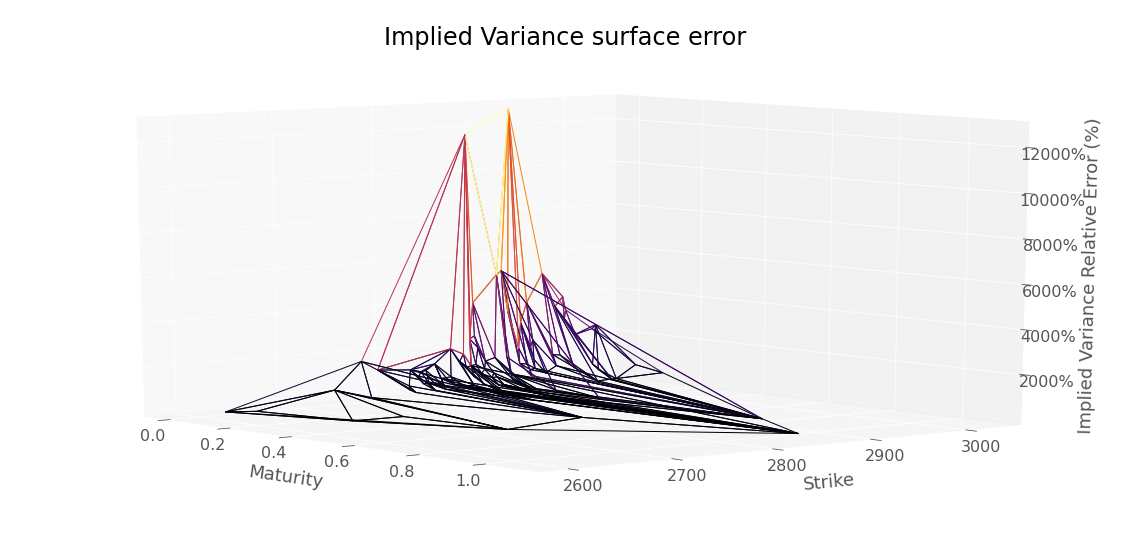

RMSE :  0.00857291947468305


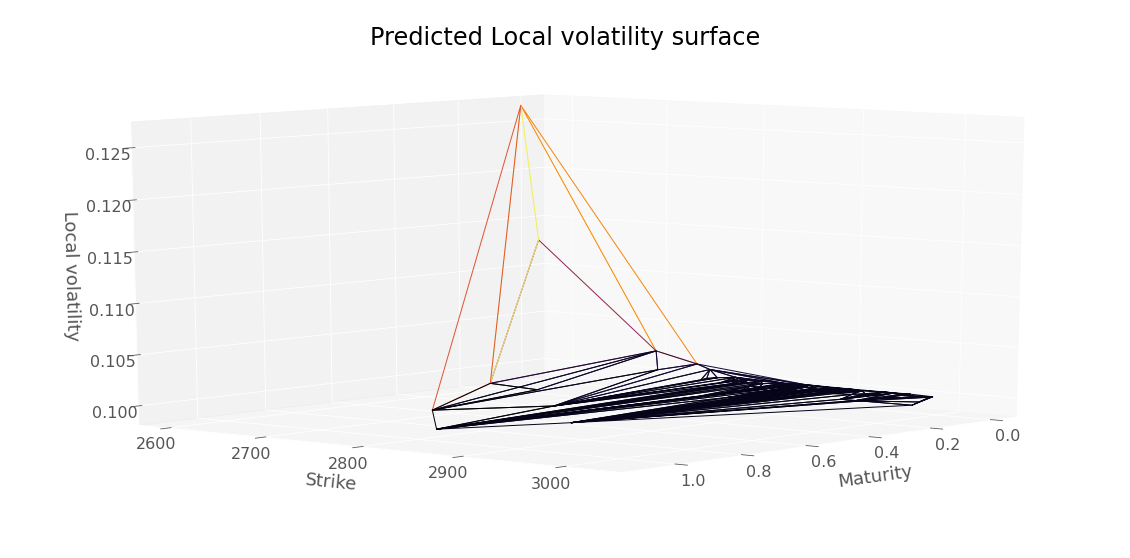

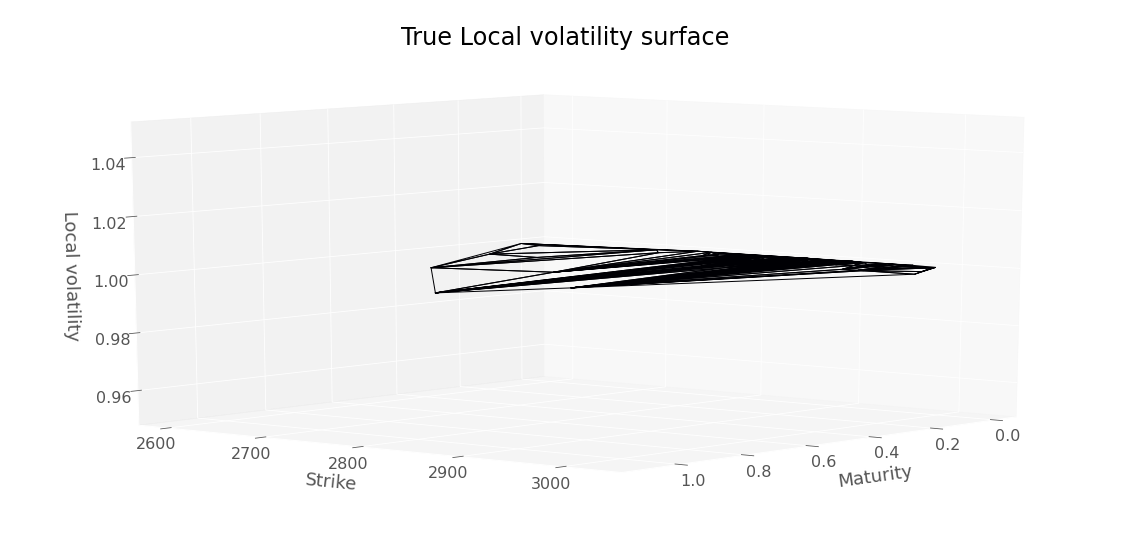

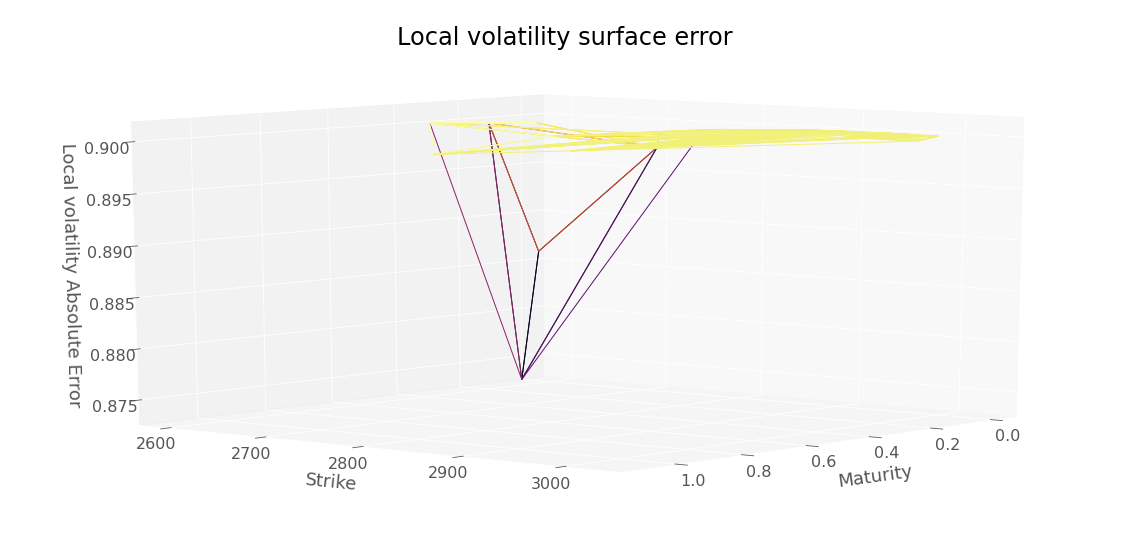

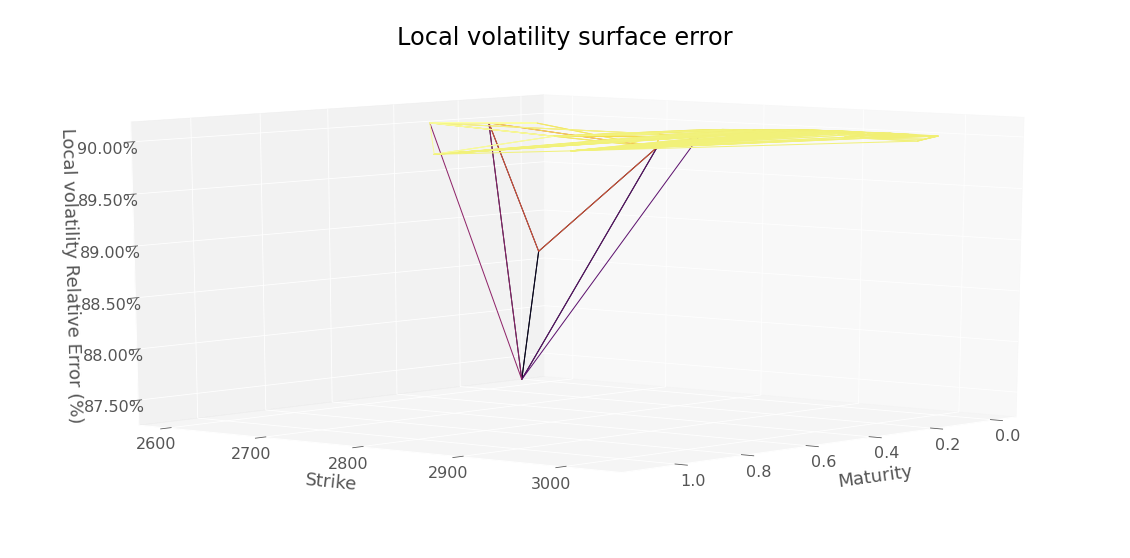

RMSE :  0.8996250215507864


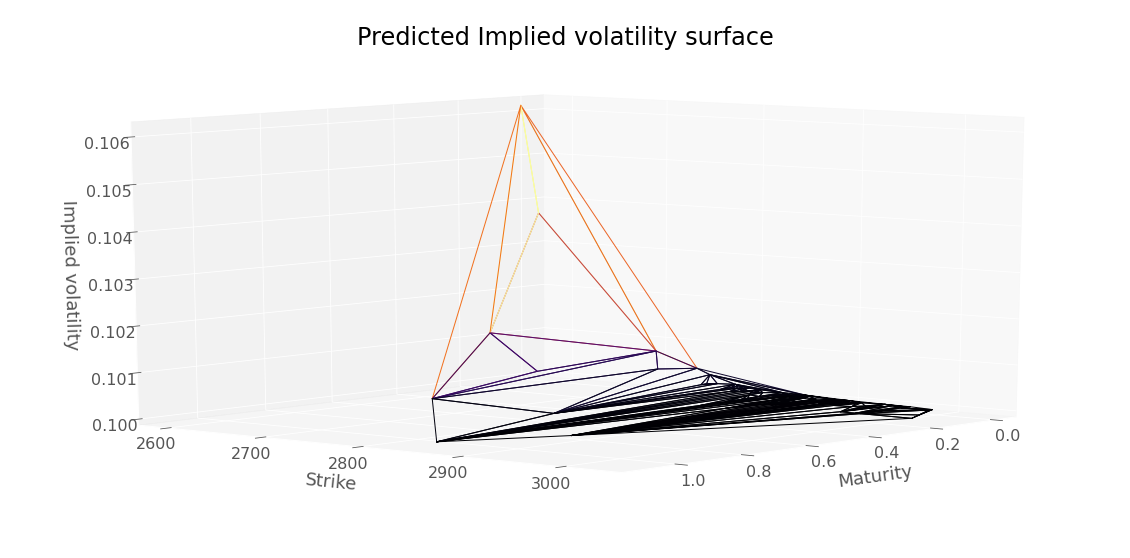

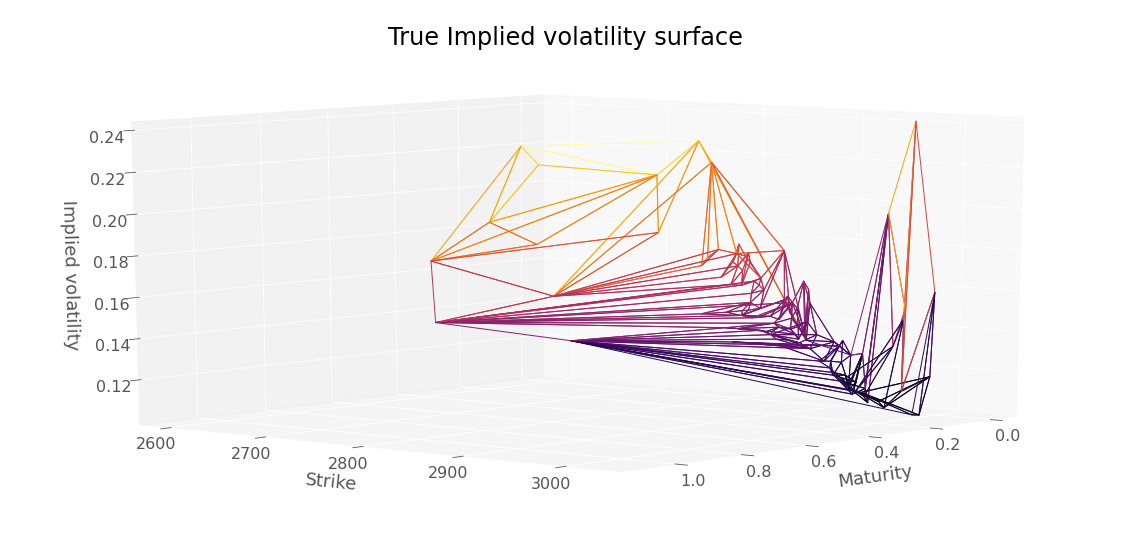

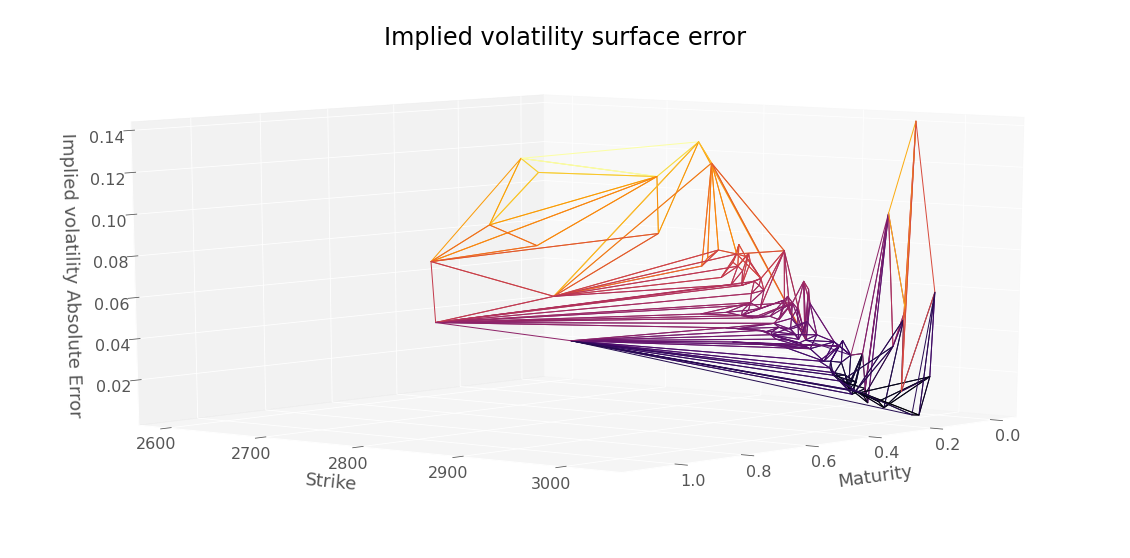

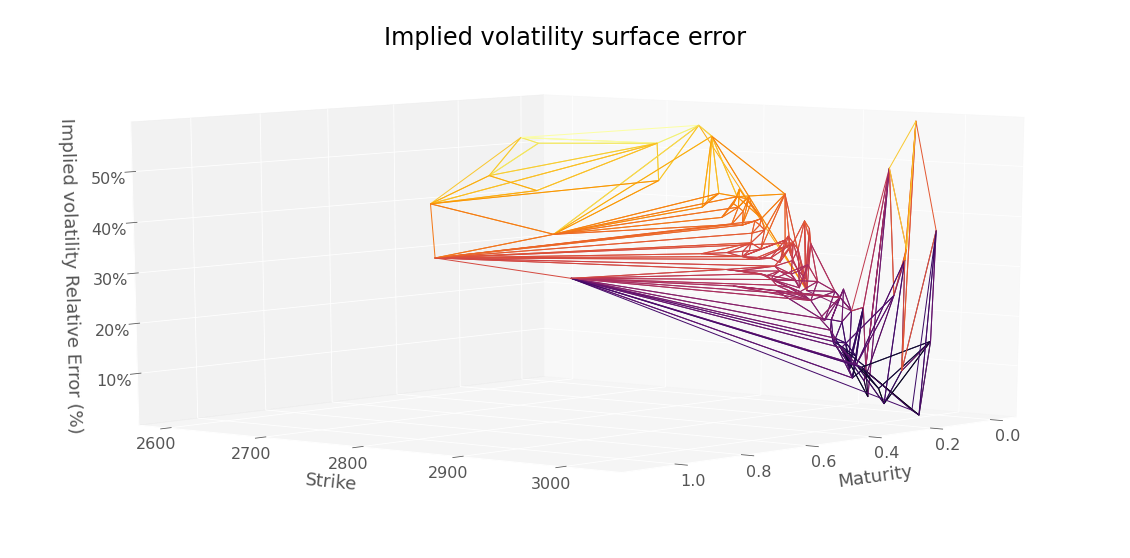

RMSE :  0.051603003562304774


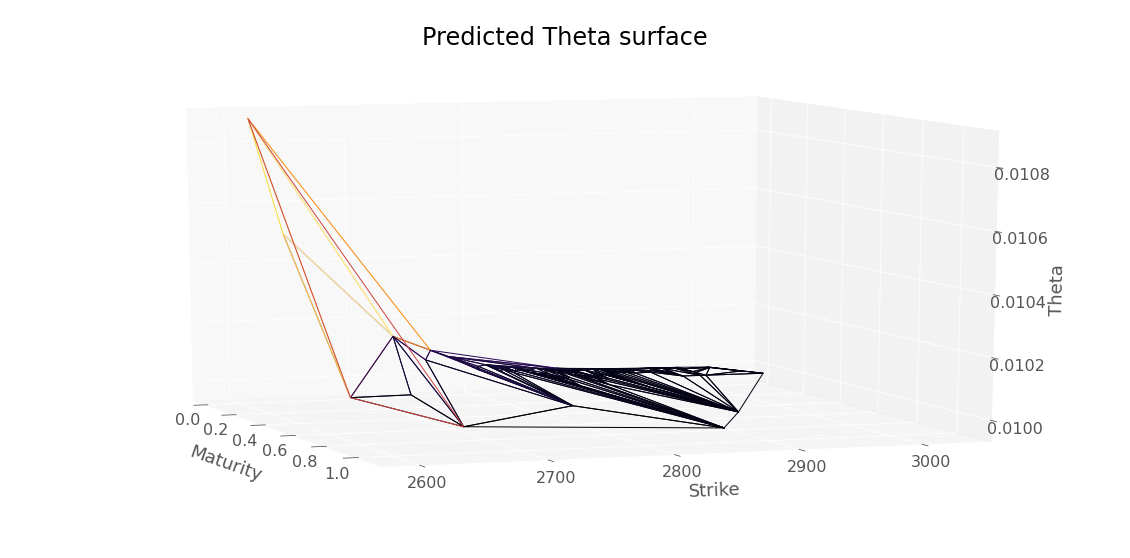

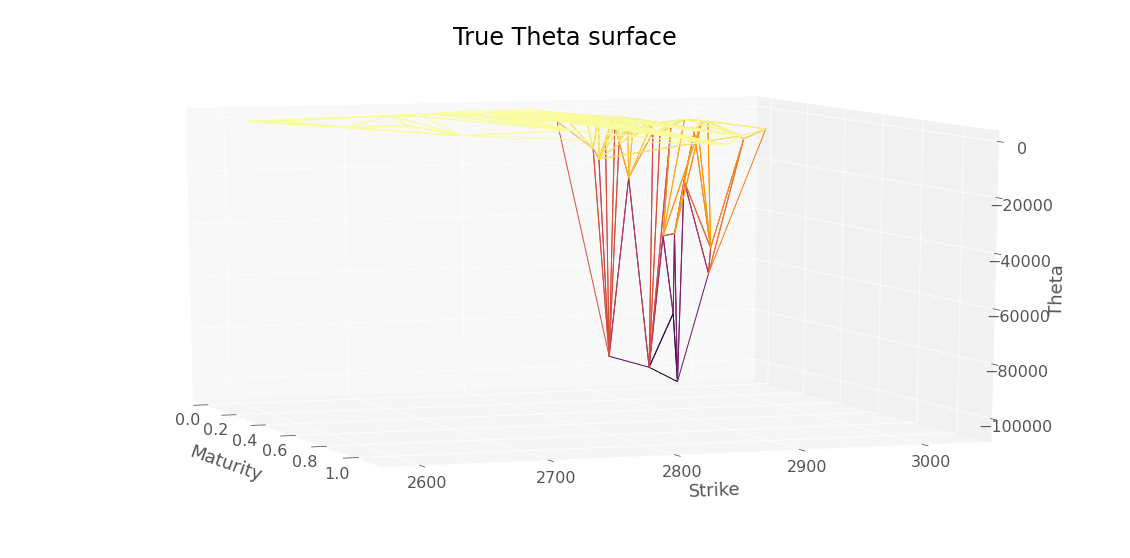

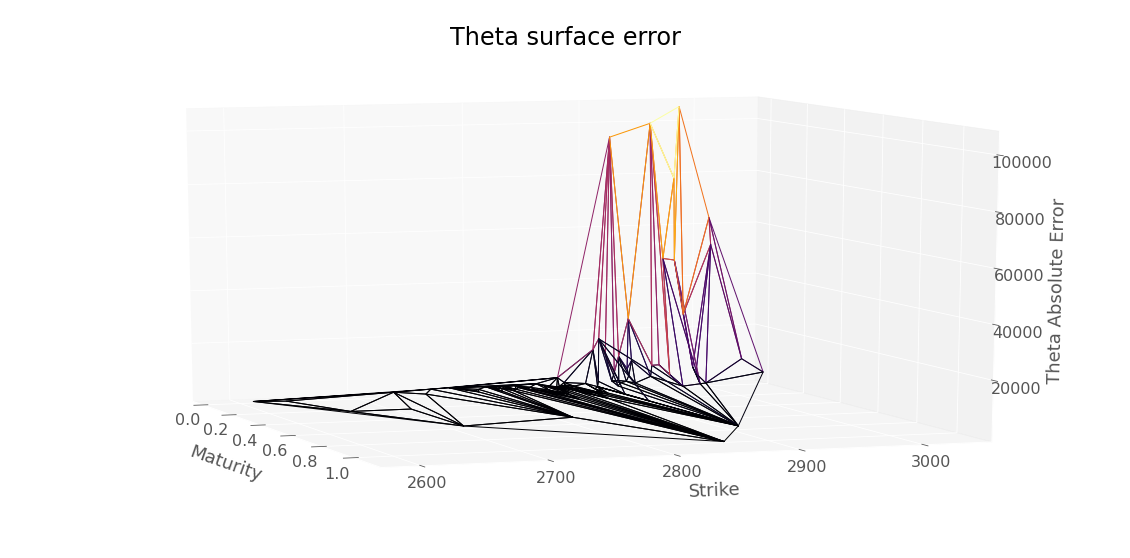

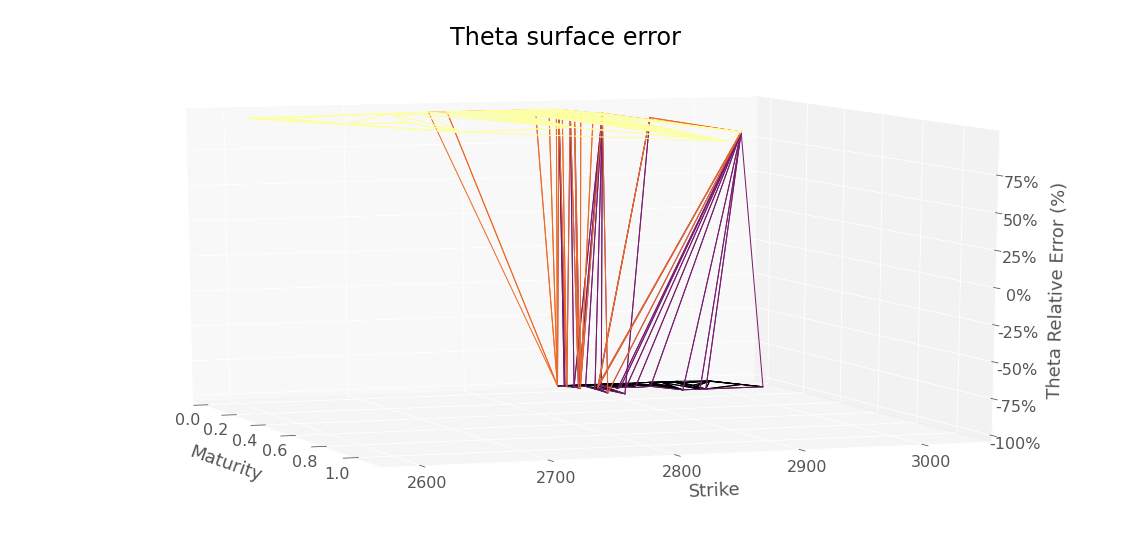

RMSE :  20844.72740119475


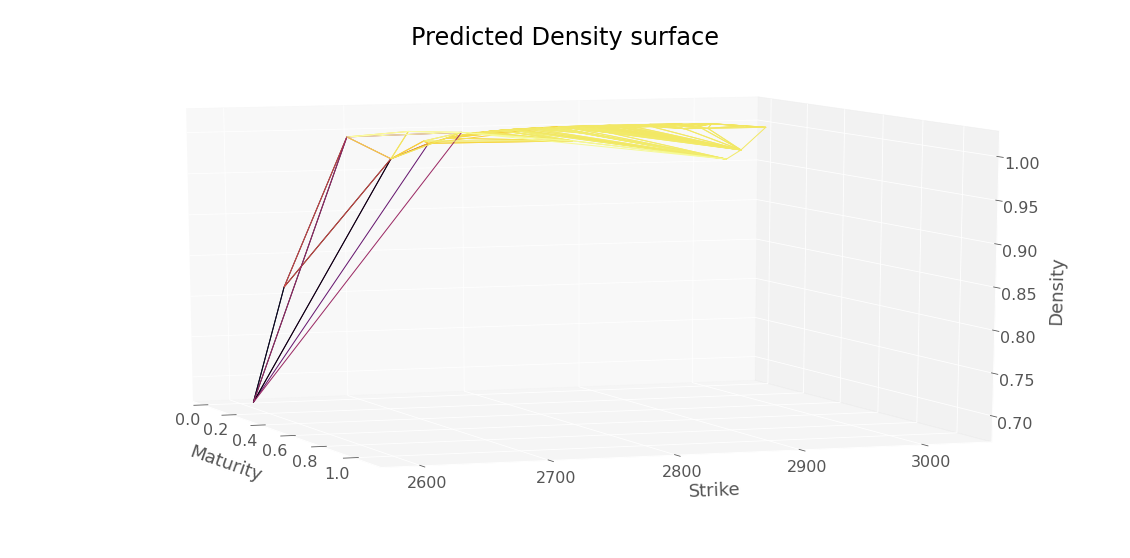

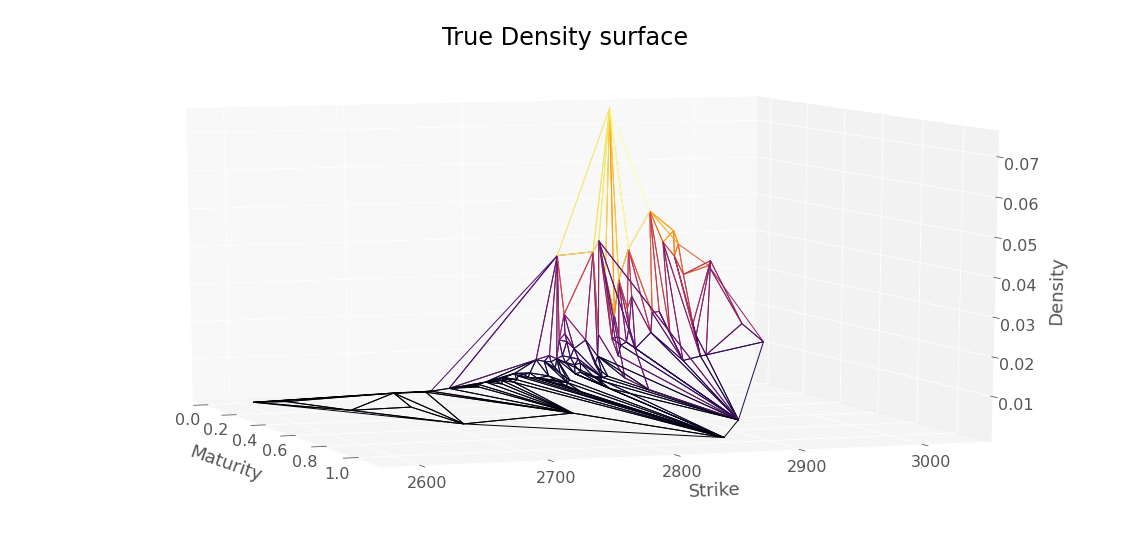

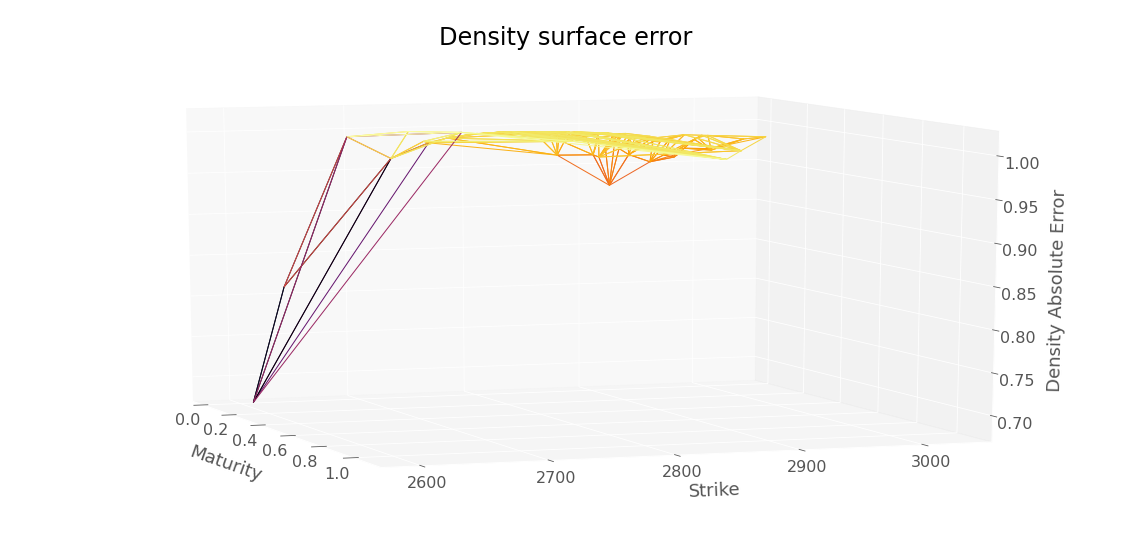

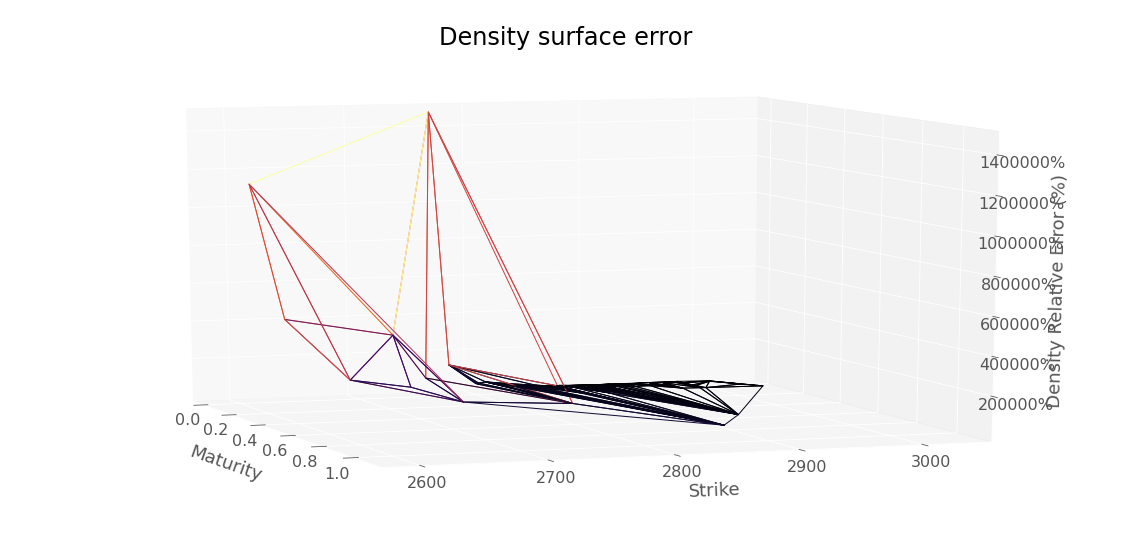

RMSE :  0.9856656471680612


In [54]:
res = neuralNetwork.create_eval_model_gatheral(neuralNetwork.NNArchitectureVanillaSoftGatheral,
                                               scaledDataSet,
                                               True,
                                               hyperparameters,
                                               scaler,
                                               modelName = "convexSoftGatheralVolModel")
y_pred4G, volLocale4G, dNN_T4G, gNN_K4G, lossSerie4G = res

plotTools.modelSummaryGatheral(y_pred4G, 
                               volLocale4G, 
                               dNN_T4G, 
                               gNN_K4G, 
                               dataSet,
                               yMin = KMin,
                               yMax = KMax)
neuralNetwork.saveDataModel(y_pred4G, 
                            volLocale4G, 
                            dNN_T4G, 
                            "convexSoftGatheralVolModelTrain")

In [93]:
volLocale4G.loc[(midS0,slice(None))]

Strike  Maturity
2860.0  0.027       0.135702
        0.055       0.163802
        0.093       0.190749
        0.131       0.210794
        0.170       0.227109
Name: Dupire, dtype: float32

Best loss (hidden nodes: 200, iterations: 0): 3.32
Best Penalization :  [20.444378, [1.1433687, 6.0709004, 3.9315248e-07]]
Number of static arbitrage violations :  7


/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


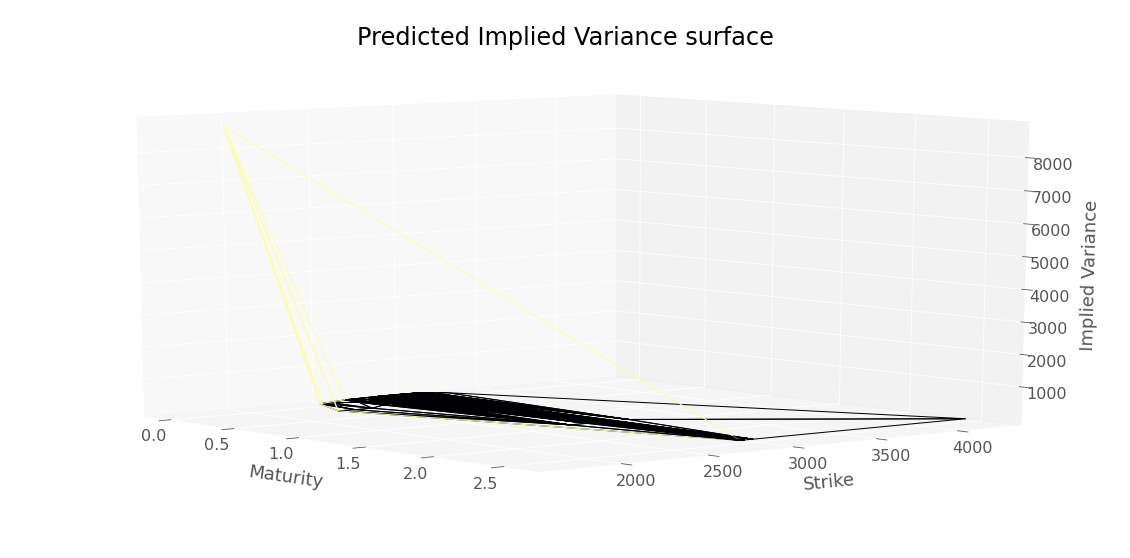

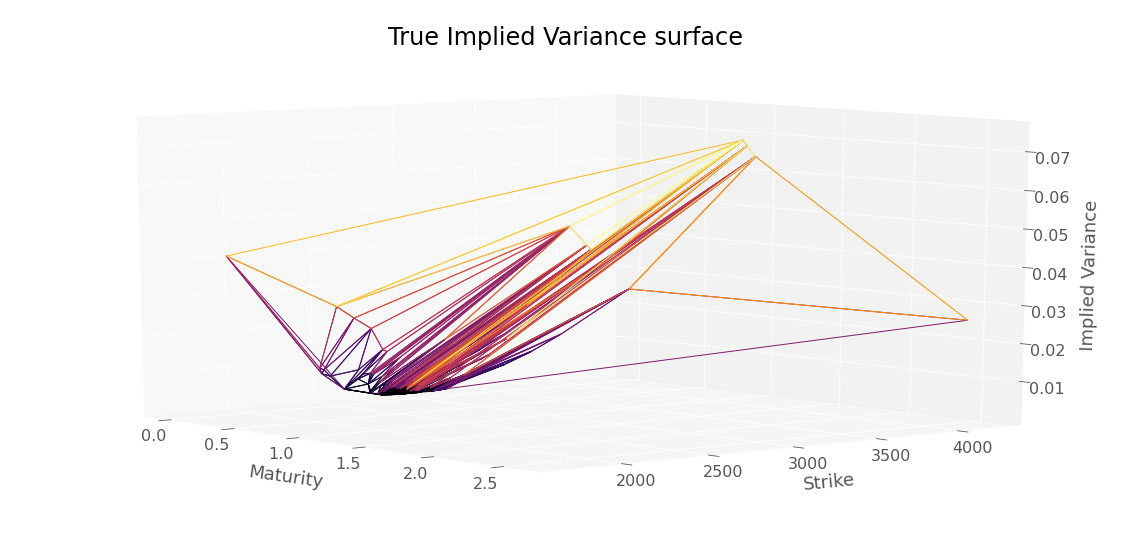

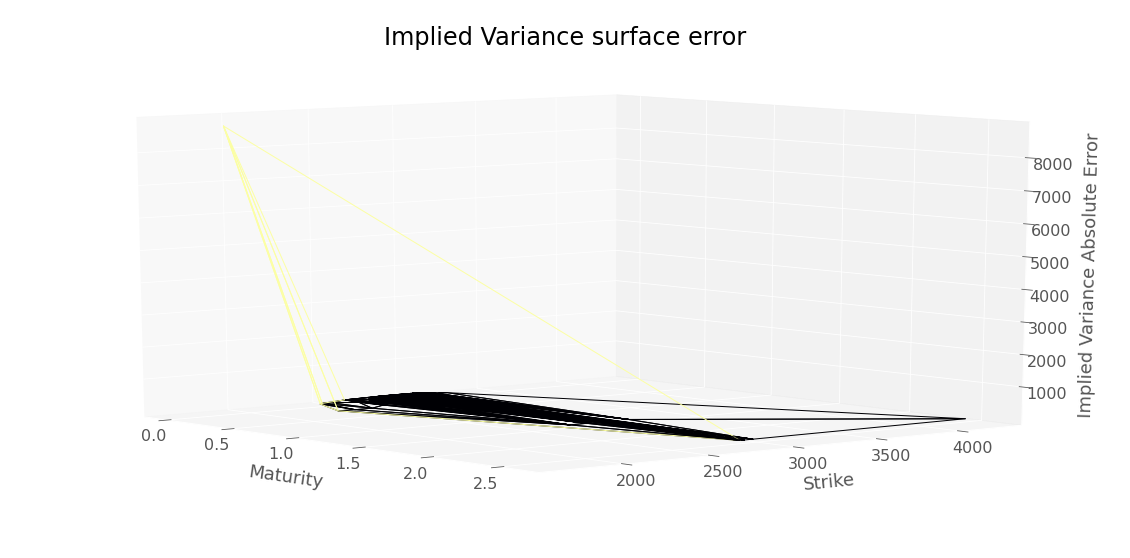

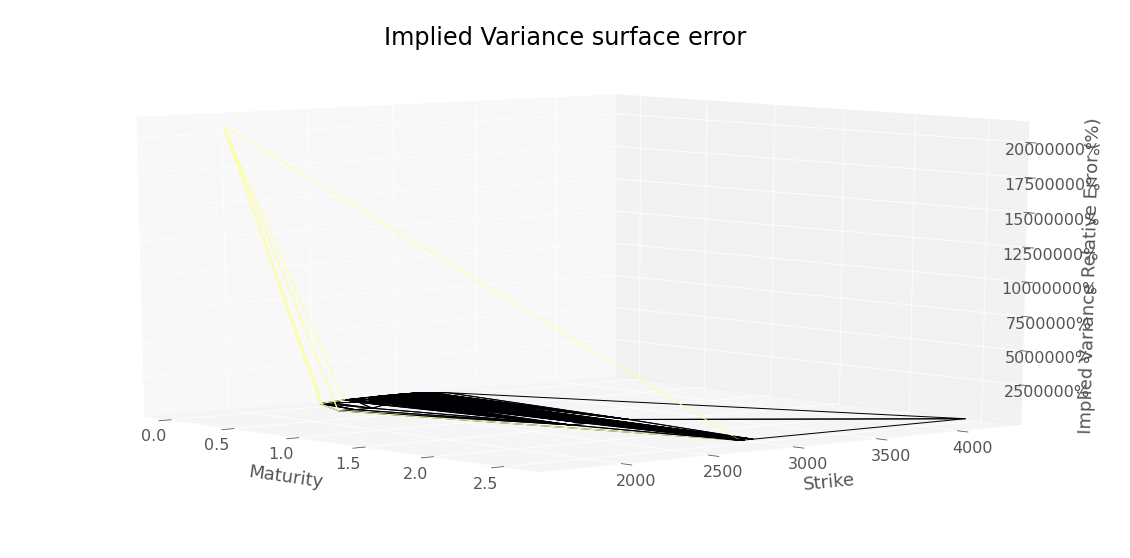

RMSE :  356.688190266305


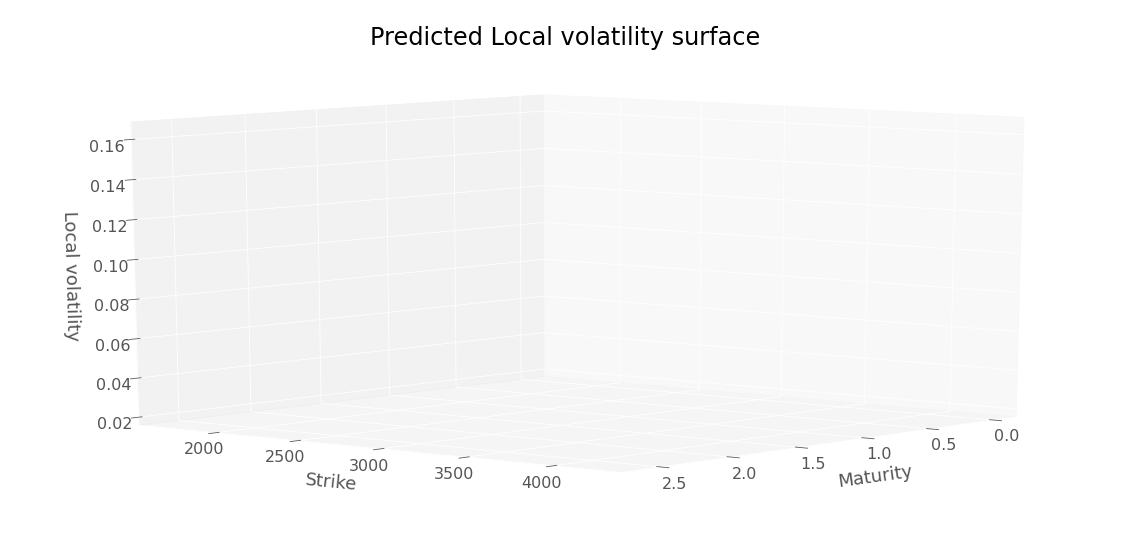

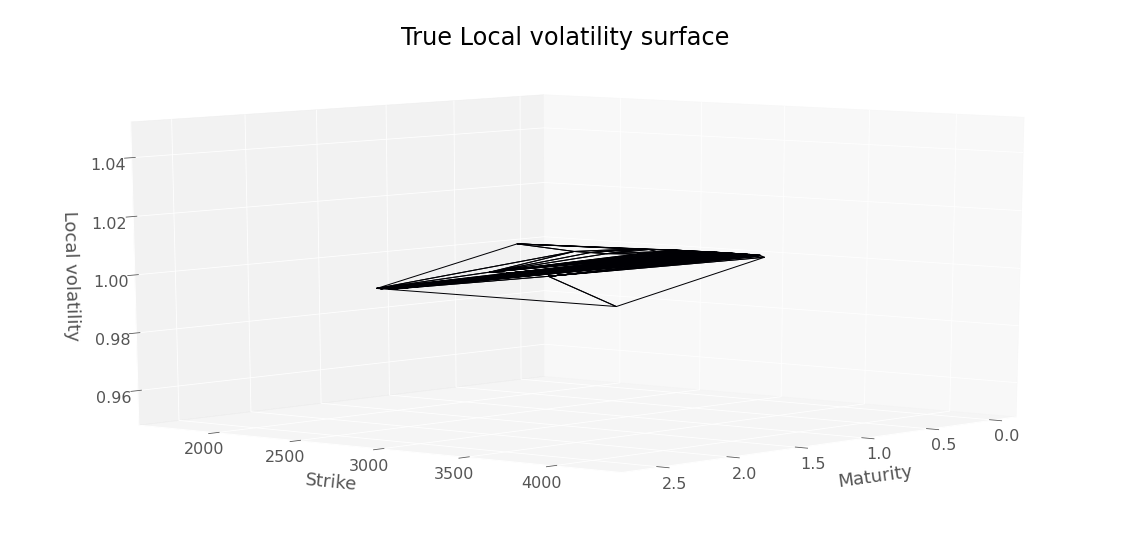

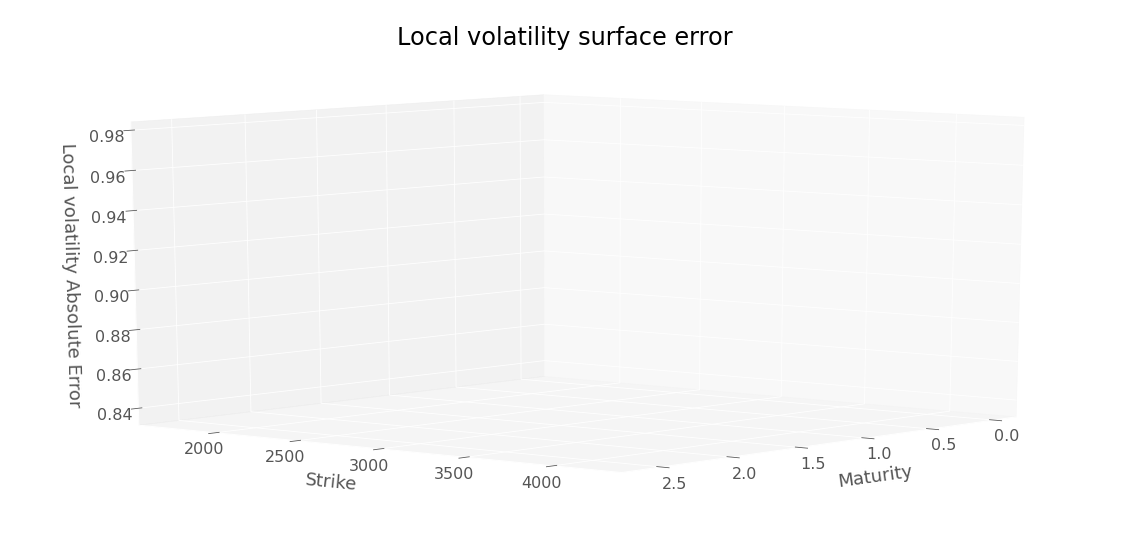

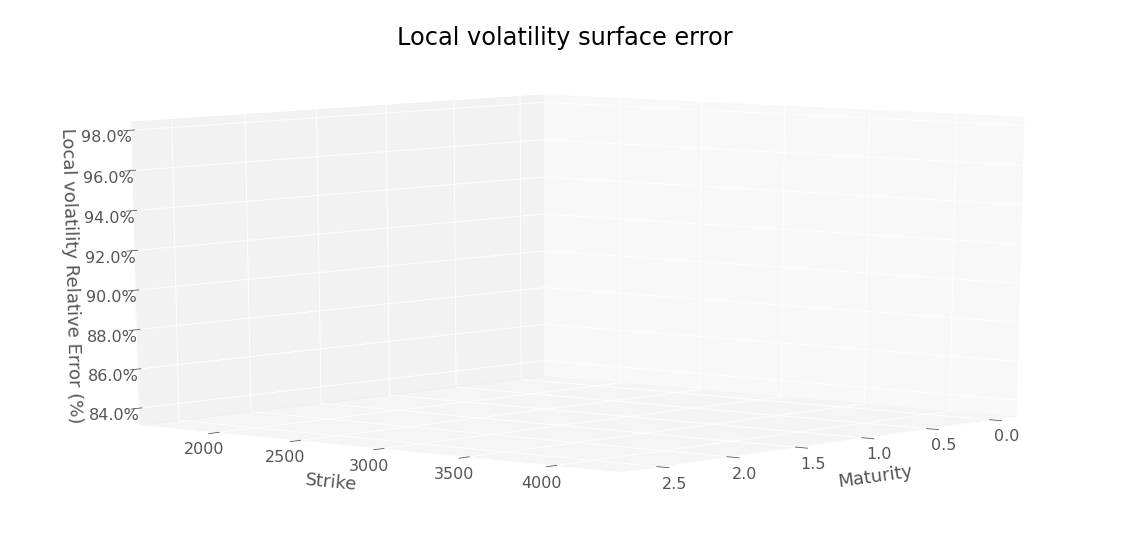

RMSE :  0.8996660345302133


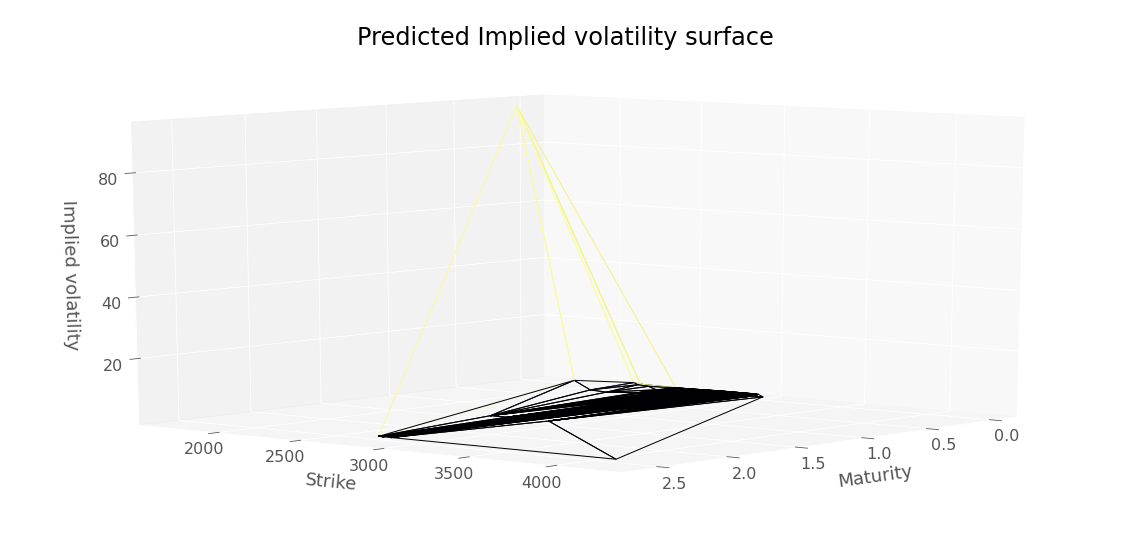

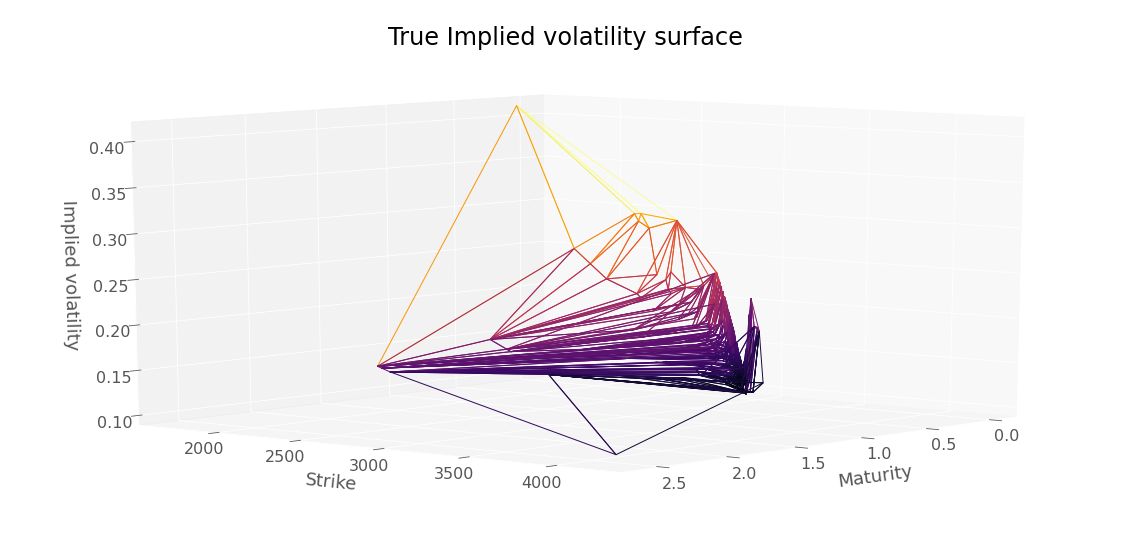

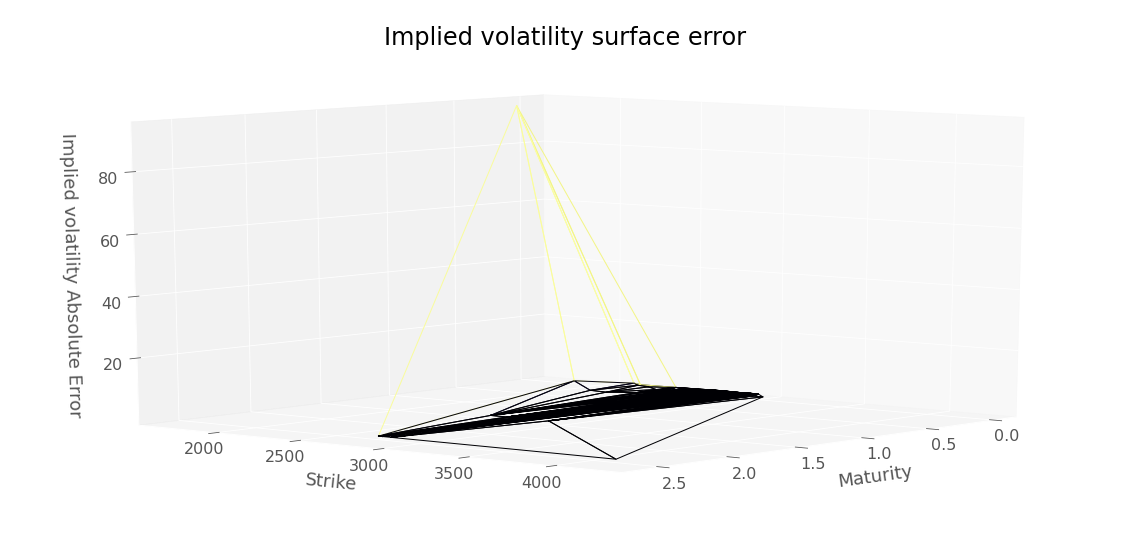

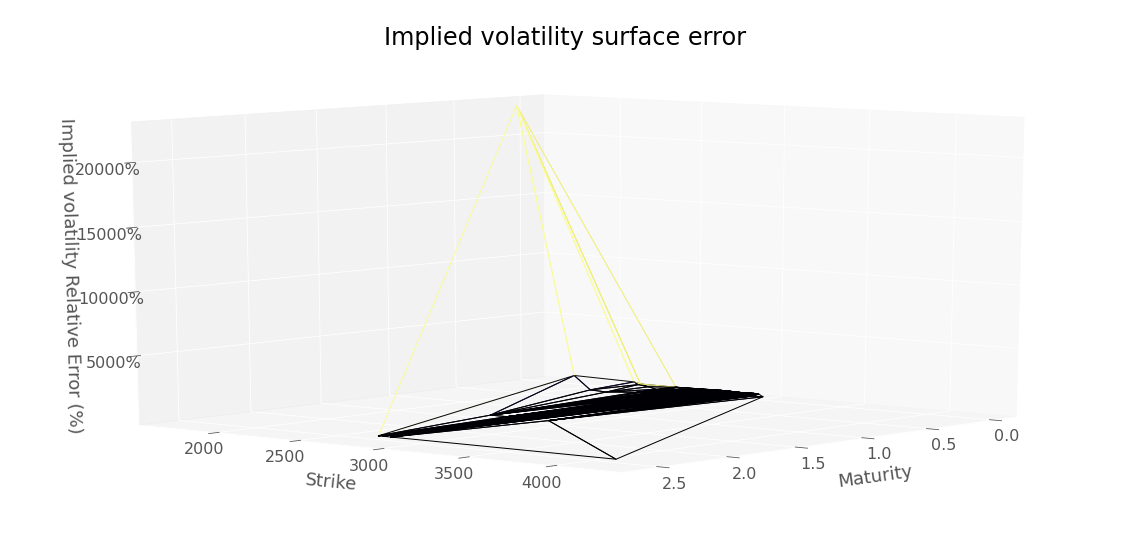

RMSE :  3.7678471402398426


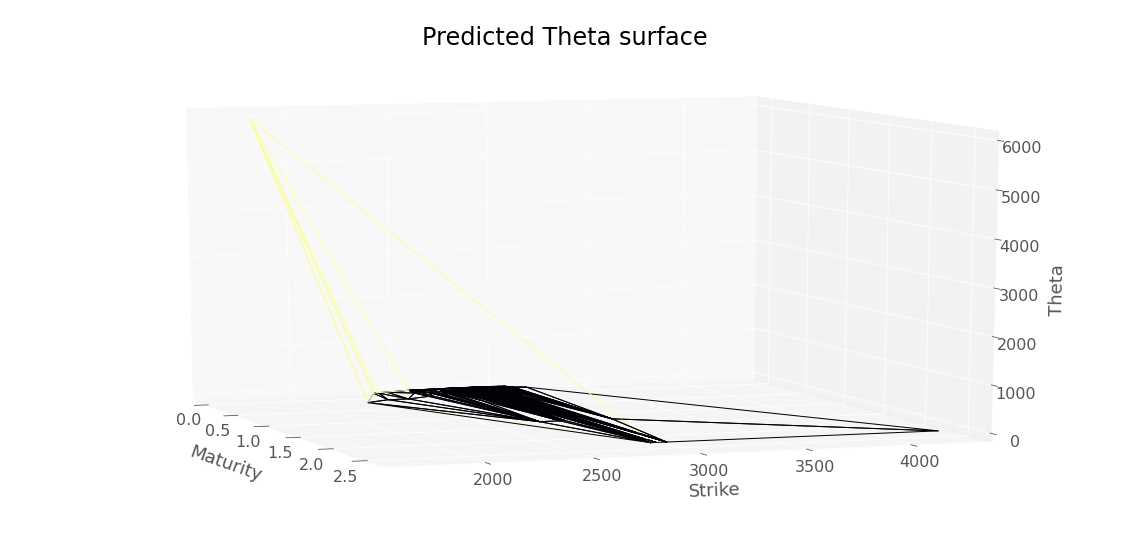

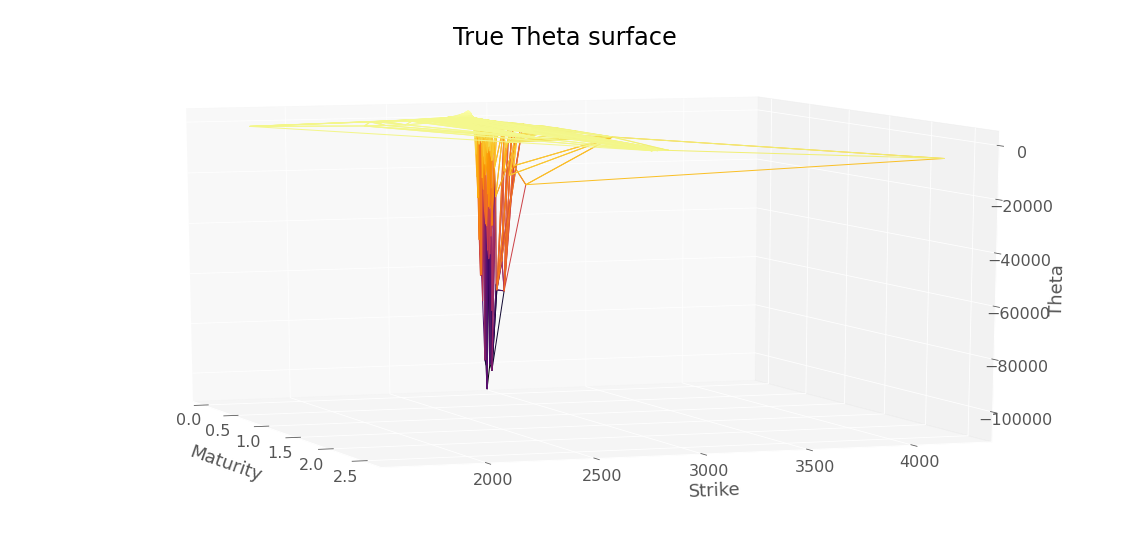

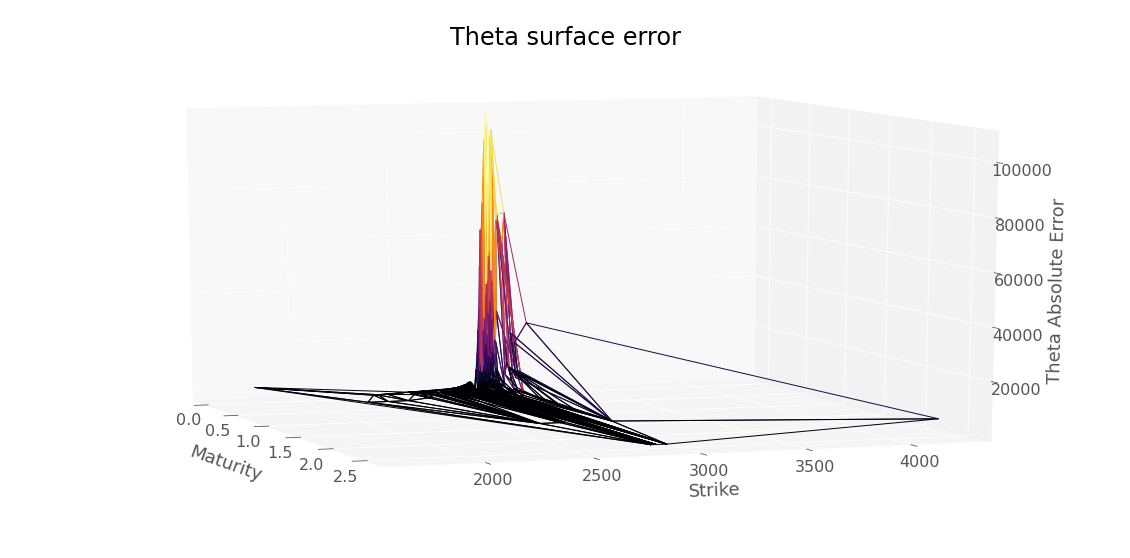

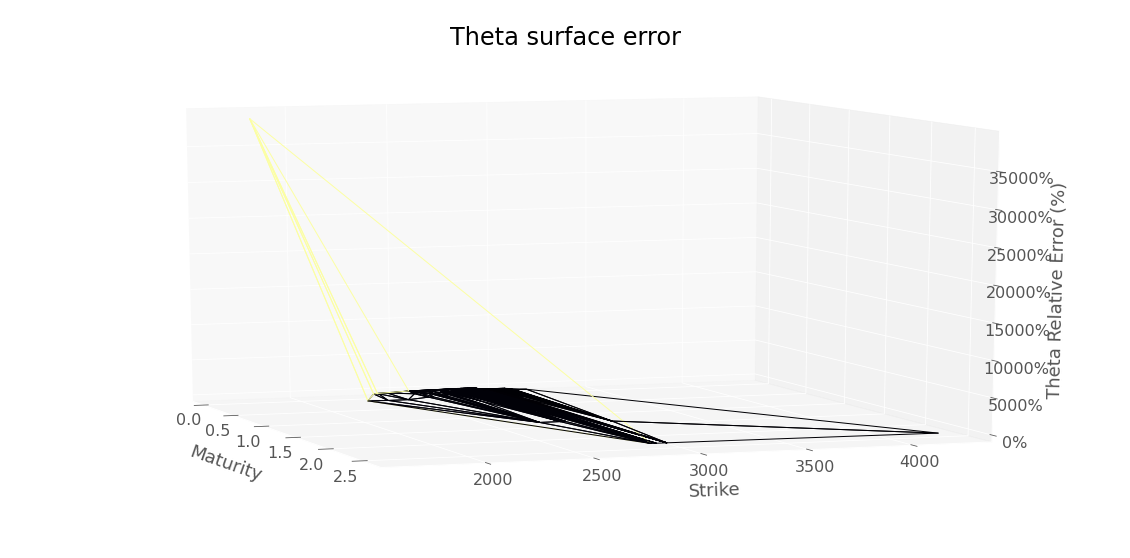

RMSE :  14124.508595098116


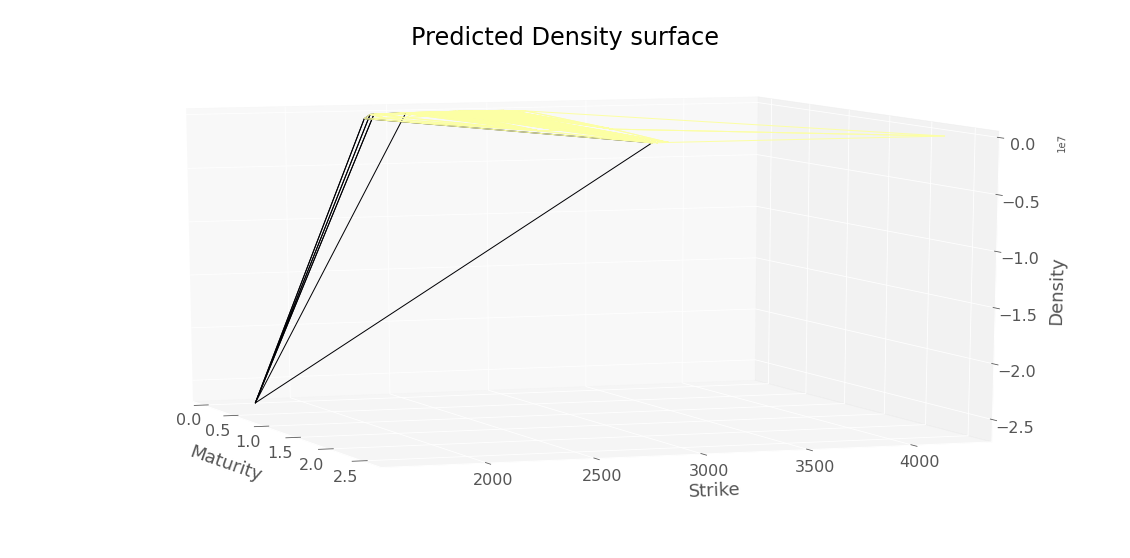

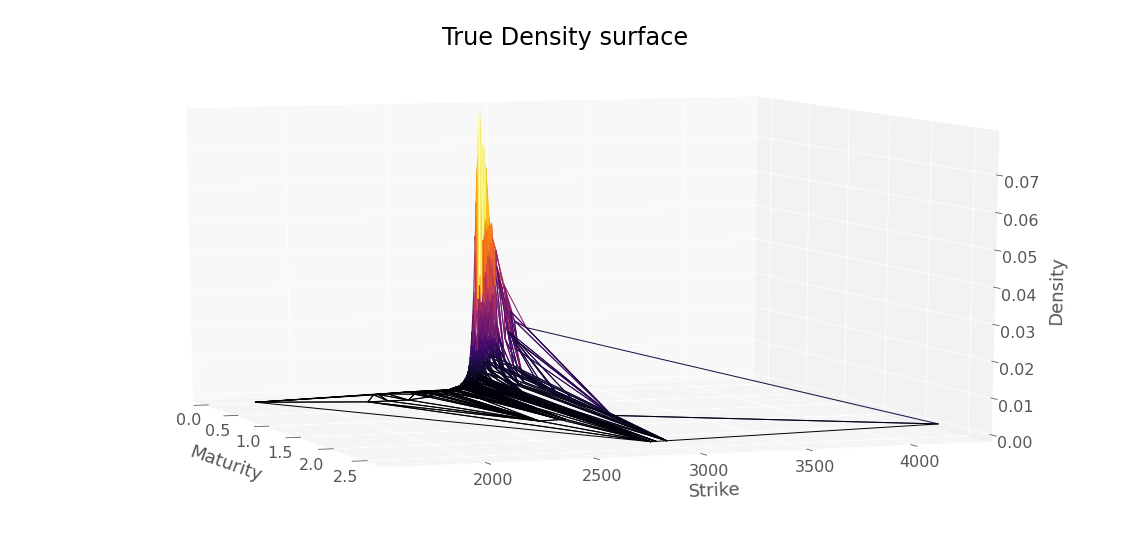

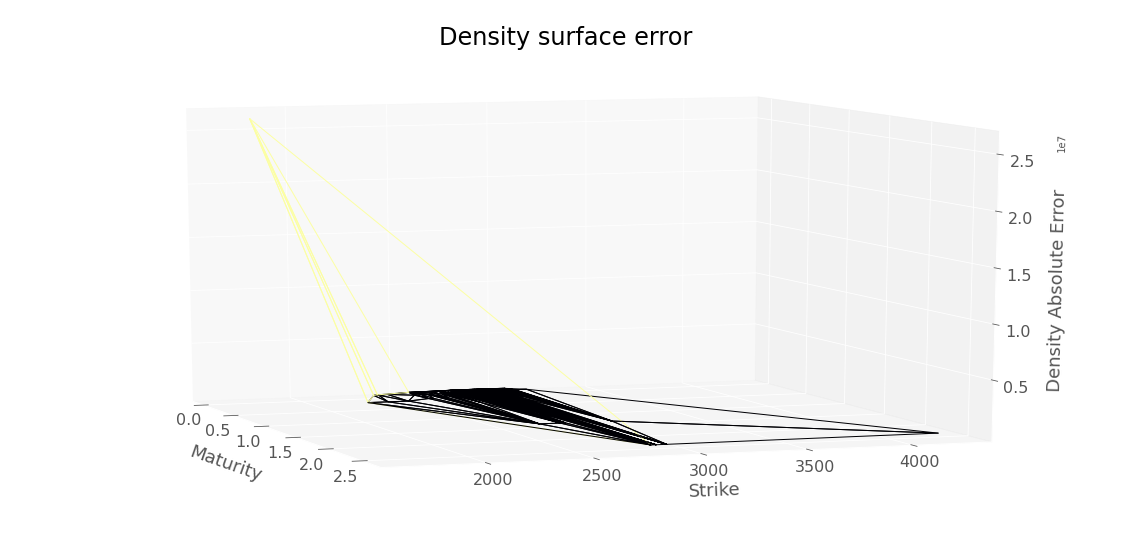

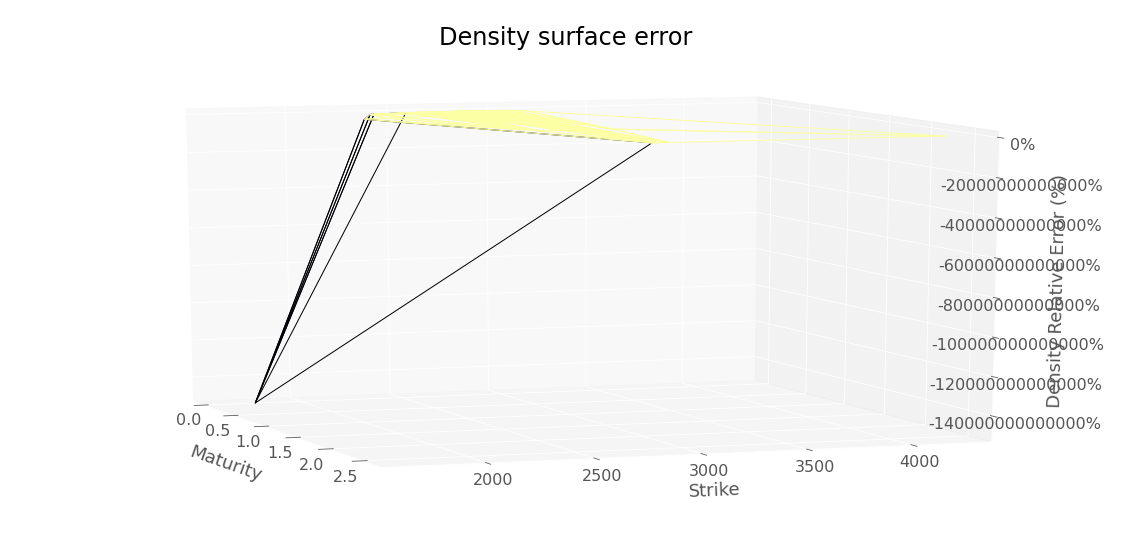

RMSE :  1061159.8603949687


In [56]:
res = neuralNetwork.create_eval_model_gatheral(neuralNetwork.NNArchitectureVanillaSoftGatheral,
                                               scaledDataSetTest,
                                               True,
                                               hyperparameters,
                                               scaler,
                                               modelName = "convexSoftGatheralVolModel")
y_pred4TestG, volLocale4TestG, dNN_T4TestG, gNN_K4TestG, lossSerie4TestG = res

plotTools.modelSummaryGatheral(y_pred4TestG, 
                               volLocale4TestG, 
                               dNN_T4TestG, 
                               gNN_K4TestG, 
                               dataSetTest,
                               yMin = KMin,
                               yMax = KMax)
neuralNetwork.saveDataModel(y_pred4TestG, 
                            volLocale4TestG, 
                            dNN_T4TestG, 
                            "convexSoftGatheralVolModelTest")

In [95]:
scaledDataSet.head()

Price     Delta  ...  impliedTotalVariance  locvol
Strike Maturity                   ...                              
1700.0 0.246      0.80 -0.004171  ...              0.042306     1.0
2300.0 0.419     14.30 -0.069169  ...              0.024620     1.0
2350.0 0.112      1.85 -0.018041  ...              0.009258     1.0
2400.0 0.093      1.60 -0.017779  ...              0.007281     1.0
2550.0 0.342     28.05 -0.151380  ...              0.014429     1.0

[5 rows x 16 columns]

In [96]:
plotTools.modelSummaryGatheral(y_pred4G[y_pred4G.index.get_level_values("Maturity") >= 0.19], 
                               volLocale4G[volLocale4G.index.get_level_values("Maturity") >= 0.19], 
                               dNN_T4G[dNN_T4G.index.get_level_values("Maturity") >= 0.19], 
                               gNN_K4G[gNN_K4G.index.get_level_values("Maturity") >= 0.19], 
                               dataSet[dataSet.index.get_level_values("Maturity") > 0.19],
                               logMoneynessScale = True)

Number of static arbitrage violations :  0


/usr/local/lib/python3.6/dist-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


TypeError: ignored

In [ ]:
plotTools.modelSummaryGatheral(y_pred4TestG, 
                               volLocale4TestG, 
                               dNN_T4TestG, 
                               gNN_K4TestG, 
                               dataSetTest[dataSetTest.index.get_level_values("Maturity") > 0.01],
                               logMoneynessScale = True)

#### Monte Carlo and PDE repricing backtests

In [ ]:
def neuralVolLocaleGatheral(s,t):
    vLoc = neuralNetwork.evalVolLocaleGatheral(neuralNetwork.NNArchitectureVanillaSoftGatheral,
                                               s, t,
                                               dataSetTest,
                                               hyperparameters,
                                               modelName = "convexSoftGatheralVolModel")
    return vLoc.dropna()

In [ ]:
volLocalInterp7 = neuralVolLocaleGatheral(volLocaleGrid[0].flatten(),
                                          volLocaleGrid[1].flatten())
volLocalInterp7.head()

In [ ]:
volLocalInterp8 = neuralVolLocaleGatheral(dataSetTest.index.get_level_values("Strike").values.flatten(),
                                          dataSetTest.index.get_level_values("Maturity").values.flatten())
volLocalInterp8.head()

In [ ]:
nnVolLocale7 = lambda x,y : backtest.interpolatedMCLocalVolatility(volLocalInterp7, x, y)

In [ ]:
nnVolLocale8 = lambda x,y : backtest.interpolatedMCLocalVolatility(volLocalInterp8, x, y)

In [ ]:
plotSerie(volLocalInterp7,
          Title = 'Interpolated Local Volatility Surface',
          az=30,
          yMin=0.0*S0,
          yMax=2.0*S0, 
          zAsPercent=True)

In [ ]:
plotSerie(volLocalInterp8,
          Title = 'Interpolated Local Volatility Surface',
          az=30,
          yMin=0.0*S0,
          yMax=2.0*S0, 
          zAsPercent=True)

In [ ]:
mcResVolLocale7 = backtest.MonteCarloPricerVectorized(S0[0],
                                                      dataSetTest,
                                                      bootstrap,
                                                      nbPaths,
                                                      nbTimeStep,
                                                      nnVolLocale7)
mcResVolLocale7.head()

In [ ]:
plotTools.predictionDiagnosis(mcResVolLocale7, 
                              dataSetTest["Price"], 
                              " Price ", 
                              yMin=4100)

In [ ]:
mcResVolLocale7.to_csv("mcResVolLocale7.csv")

In [ ]:
mcResVolLocale8 = backtest.MonteCarloPricerVectorized(S0[0],
                                                      dataSetTest,
                                                      bootstrap,
                                                      nbPaths,
                                                      nbTimeStep,
                                                      nnVolLocale8)
mcResVolLocale8.head()

In [ ]:
plotTools.predictionDiagnosis(mcResVolLocale8, 
                              dataSetTest["Price"], 
                              " Price ", 
                              yMin=4100)

In [ ]:
mcResVolLocale8.to_csv("mcResVolLocale8.csv")

# Hyperparameter selection

In [ ]:
neuralNetwork.selectHyperparametersRandom(hyperparameters,
                                          ["lambdaLocVol","lambdaSoft","lambdaGamma"],
                                          neuralNetwork.NNArchitectureConstrainedRawDupire,
                                          "hyperParameters",
                                          True, 
                                          100,
                                          logGrid = True)

In [ ]:
hyperparameters["lambdaLocVol"] = 100
hyperparameters["lambdaSoft"] = 100 
hyperparameters["lambdaGamma"] = 10000

In [ ]:
neuralNetwork.selectHyperparameters(hyperparameters, 
                                    "lambdaLocVol", 
                                    neuralNetwork.NNArchitectureVanillaSoftDupire, 
                                    "hyperParameters", 
                                    True, 
                                    logGrid = True)

In [ ]:
neuralNetwork.selectHyperparameters(hyperparameters, 
                                    "DupireVarCap", 
                                    NNArchitectureConstrainedRawDupire, 
                                    "hyperParameters", 
                                    True, 
                                    logGrid = True)

In [ ]:
neuralNetwork.selectHyperparameters(hyperparameters, 
                                    "lambdaLocVol", 
                                    neuralNetwork.NNArchitectureUnconstrainedDupire, 
                                    "hyperParameters", 
                                    True, 
                                    logGrid = True)



In [ ]:
hyperparameters["lambdaLocVol"] = 100



In [ ]:
neuralNetwork.selectHyperparameters(hyperparameters, 
                                    "lambdaLocVol", 
                                    neuralNetwork.NNArchitectureConstrainedRawDupire, 
                                    "hyperParameters", 
                                    True, 
                                    logGrid = True)



In [ ]:
hyperparameters["nbUnits"] = 40



In [ ]:
neuralNetwork.selectHyperparameters(hyperparameters, 
                                    "nbUnits", 
                                    neuralNetwork.NNArchitectureVanillaSoftDupire, 
                                    "hyperParameters", 
                                    True, 
                                    logGrid = False)



In [ ]:
hyperparameters["nbUnits"] = 200


In [ ]:
neuralNetwork.selectHyperparameters(hyperparameters, 
                                    "lambdaLocVol", 
                                    neuralNetwork.NNArchitectureConstrainedRawDupire, 
                                    "hyperParameters", 
                                    True, 
                                    logGrid = True)



In [ ]:
hyperparameters["nbUnits"] = 40



In [ ]:
neuralNetwork.selectHyperparameters(hyperparameters, 
                                    "nbUnits", 
                                    neuralNetwork.NNArchitectureVanillaSoftDupire, 
                                    "hyperParameters", 
                                    True, 
                                    logGrid = False)



In [ ]:
hyperparameters["nbUnits"] = 200